# **Realisé par : Donia Tekaya et Elyes Maalel**

In [1]:
!pip install torch
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


# **Importation des bibliothèques**

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA


import random
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# **Application de plusieurs méthodes de selection des caractéristiques**

In [3]:


# Charger les données d'entraînement et de test
train_data = pd.read_csv('data.csv')
test_data = pd.read_csv("/content/test.csv", sep=";")  # Utilise le bon séparateur

# Séparer les caractéristiques et la variable cible (garder la colonne 'class' pour l'entraînement)
X_train = train_data.drop(columns=["class"])
y_train = train_data["class"]

# Normalisation des données (appliquer la même transformation aux données de test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_data)

# 1. Application de RFE (Recursive Feature Elimination)
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
rfe = RFE(log_reg, n_features_to_select=20)  # Sélectionner 20 caractéristiques
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# 2. Application de Lasso pour la sélection de caractéristiques
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)
lasso_selected_features = np.abs(lasso.coef_) > 0
X_train_lasso = X_train_scaled[:, lasso_selected_features]
X_test_lasso = X_test_scaled[:, lasso_selected_features]

# 3. Application de PCA pour capturer 95% de la variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Ajouter la colonne 'class' dans les données transformées de l'entraînement
train_rfe = pd.DataFrame(X_train_rfe)
train_rfe['class'] = y_train.values
train_lasso = pd.DataFrame(X_train_lasso)
train_lasso['class'] = y_train.values
train_pca = pd.DataFrame(X_train_pca)
train_pca['class'] = y_train.values

# Sauvegarde des résultats dans des fichiers CSV pour une exploitation future
train_rfe.to_csv("train_rfe.csv", index=False)
pd.DataFrame(X_test_rfe).to_csv("test_rfe.csv", index=False)

train_lasso.to_csv("train_lasso.csv", index=False)
pd.DataFrame(X_test_lasso).to_csv("test_lasso.csv", index=False)

train_pca.to_csv("train_pca.csv", index=False)
pd.DataFrame(X_test_pca).to_csv("test_pca.csv", index=False)

# Afficher les formes des données transformées
print(f"RFE: Train shape: {X_train_rfe.shape}, Test shape: {X_test_rfe.shape}")
print(f"Lasso: Train shape: {X_train_lasso.shape}, Test shape: {X_test_lasso.shape}")
print(f"PCA: Train shape: {X_train_pca.shape}, Test shape: {X_test_pca.shape}")



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.982e-03, tolerance: 2.437e-03
  model = cd_fast.enet_coordinate_descent(


RFE: Train shape: (104, 20), Test shape: (70, 20)
Lasso: Train shape: (104, 111), Test shape: (70, 111)
PCA: Train shape: (104, 72), Test shape: (70, 72)


# **Depart avec un reseau de neurone d'une seule couche cachée et un seul neurone: regression logistique**

In [17]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

seed = 42
data = pd.read_csv("/content/train_rfe.csv")

X = data.drop(columns=['class'])
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_train= X_train + np.random.normal(0, 0.01, X_train.shape)
X_test = scaler.transform(X_test)

In [19]:
# Appliquer SMOTE pour équilibrer les classes dans l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

min_size = min(X_test_tensor.shape[0], y_test_tensor.shape[0])
X_test_tensor = X_test_tensor[:min_size]
y_test_tensor = y_test_tensor[:min_size]
y_train_tensor = y_train_tensor.view(-1)
y_test_tensor = y_test_tensor.view(-1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

num_epochs = 60
best_auc = 0

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()


        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)

        # Passage arrière
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            y_test_pred = model(X_test_tensor).squeeze()
            y_test_pred_class = torch.round(y_test_pred)

        y_test_numpy = y_test_tensor.numpy()
        y_test_pred_numpy = y_test_pred_class.numpy()

        f1 = f1_score(y_test_numpy, y_test_pred_numpy)
        print(f"F1 Score: {f1:.4f}")

        auc = roc_auc_score(y_test_numpy, y_test_pred_numpy)
        print(f"AUC: {auc:.4f}")

        cm = confusion_matrix(y_test_numpy, y_test_pred_numpy)
        print("Confusion Matrix:")
        print(cm)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

        if auc > best_auc :
          print(f">>> Saving best model : AUC score increased from {best_auc} to {auc}")
          best_auc = auc

F1 Score: 0.8627
AUC: 0.8224
Confusion Matrix:
[[13  4]
 [ 3 22]]
Epoch 10/60, Loss: 0.5120535492897034
>>> Saving best model : AUC score increased from 0 to 0.8223529411764705
F1 Score: 0.9020
AUC: 0.8718
Confusion Matrix:
[[14  3]
 [ 2 23]]
Epoch 20/60, Loss: 0.38753652572631836
>>> Saving best model : AUC score increased from 0.8223529411764705 to 0.8717647058823529
F1 Score: 0.9412
AUC: 0.9212
Confusion Matrix:
[[15  2]
 [ 1 24]]
Epoch 30/60, Loss: 0.36456915736198425
>>> Saving best model : AUC score increased from 0.8717647058823529 to 0.9211764705882353
F1 Score: 0.9600
AUC: 0.9506
Confusion Matrix:
[[16  1]
 [ 1 24]]
Epoch 40/60, Loss: 0.3834003508090973
>>> Saving best model : AUC score increased from 0.9211764705882353 to 0.9505882352941176
F1 Score: 0.9600
AUC: 0.9506
Confusion Matrix:
[[16  1]
 [ 1 24]]
Epoch 50/60, Loss: 0.2890852987766266
F1 Score: 0.9600
AUC: 0.9506
Confusion Matrix:
[[16  1]
 [ 1 24]]
Epoch 60/60, Loss: 0.22846007347106934


# **Chercher la meilleure architecture d'un reseau de neurone multicouches et multineurones en utilisant Optuna**

Optuna utilise l'optimisation bayésienne pour minimiser la fonction de perte en recherchant les hyperparamètres optimaux. Il construit un modèle probabiliste
(le Tree-structured Parzen Estimator, TPE) qui estime la distribution des hyperparamètres en fonction des performances des essais précédents.
Ce modèle divise les hyperparamètres en deux groupes : ceux qui donnent de bons résultats et ceux qui en donnent de moins bons.
Ensuite, une fonction d'acquisition (comme l'amélioration attendue) guide Optuna pour choisir les prochains hyperparamètres à tester,
 en équilibrant l'exploration de nouvelles zones et
 l'exploitation des zones déjà prometteuses. Ce processus itératif permet à Optuna de converger vers les meilleurs hyperparamètres avec un nombre limité d'essais.

 Fonction d'acquisition, en revanche, est une composante clé de l'optimisation bayésienne. Elle guide le choix des prochains points à tester en fonction du modèle de substitution (comme le TPE dans Optuna) qui estime la performance des hyperparamètres. Elle équilibre l'exploitation des régions qui semblent prometteuses et l'exploration des régions sous-explorées pour potentiellement découvrir de meilleurs résultats.

In [9]:
#Fixer une graine aléatoire à 42
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


# Charger les données depuis un fichier CSV
data = pd.read_csv("/content/train_rfe.csv")  # Assure-toi de spécifier le chemin correct

# Séparer les caractéristiques et la cible
X = data.drop(columns=["class"])  # Remplace "class" par le nom de ta colonne cible
y = data["class"]

# Split des données en ensemble d'entraînement et de validation (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisation des données
# On normalise les données du train pour permettre au modele de mieux converger en empechant les valeurs extremes d'influencer
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Conversion des données en tenseurs PyTorch
#On utilise des tenseurs pas des numpy parce que on veut qu il fonctionne sur le GPU cela permet d'accelerer les calculs
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour la cible
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

# Créer les datasets et dataloaders pour l'entraînement et la validation
# train_dataset :creation d'un objet qui combine 2 tenseurs
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
#Data loader : permet de decouper a chaque iteration un grand ensemble de données en petit batchs a chaque iteration
"""chaque mise a jour de touts les poids d'un reseau de neurone correspond a une iteration
et pour cette mise a jour complete on utilise un batch different de celui de l autre mise a jour"""

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Modèle à plusieurs couches avec Dropout et BCEWithLogitsLoss

#on a layers une liste on va stocker dedans le nombre de neurone de chaque couche
#hidden dims: c est le nombre de couches caches
class MultiLayerOptimizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate, activation_fn):
        super(MultiLayerOptimizedModel, self).__init__()
        self.layers = nn.ModuleList()

        # Première couche (input vers hidden[0])
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))

        # Couches cachées avec Dropout
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.layers.append(nn.Dropout(dropout_rate))

        # Couche de sortie (1 neurone pour la classification binaire)
        self.layers.append(nn.Linear(hidden_dims[-1], 1))

        # Fonction d'activation
        self.activation_fn = activation_fn
#forward: fonction qui fait passer les donnees a travers le reseau
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear) and i != len(self.layers) - 1:
                x = self.activation_fn(layer(x))  # Activation pour chaque couche cachée
            elif isinstance(layer, nn.Dropout):
                x = layer(x)  # Appliquer Dropout
            else:
                x = layer(x)  # Pas de Sigmoid ici, car on utilise BCEWithLogitsLoss
        return x
#Optuna: bibliotheque d'optimisation d'hypermarametre: utilise les techniques de l'optimisation bayesienne pour trouver les meilleurs valeurs d'hyperparametres
"""Optuna utilise l'optimisation bayésienne pour minimiser la fonction de perte en recherchant les hyperparamètres optimaux. Il construit un modèle probabiliste
(le Tree-structured Parzen Estimator, TPE) qui estime la distribution des hyperparamètres en fonction des performances des essais précédents.
Ce modèle divise les hyperparamètres en deux groupes : ceux qui donnent de bons résultats et ceux qui en donnent de moins bons.
Ensuite, une fonction d'acquisition (comme l'amélioration attendue) guide Optuna pour choisir les prochains hyperparamètres à tester,
 en équilibrant l'exploration de nouvelles zones et
 l'exploitation des zones déjà prometteuses. Ce processus itératif permet à Optuna de converger vers les meilleurs hyperparamètres avec un nombre limité d'essais."""
# Fonction objectif pour Optuna avec BCEWithLogitsLoss et EarlyStopping: cherche a minimiser la perte
def objective(trial):
    # Hyperparamètres à optimiser
    n_layers = trial.suggest_int('n_layers', 1, 5)  # Tester jusqu'à 10 couches cachées

    #trial.suggest_int permet de tester differentes valeurs d'hyperparametre
    #nn.dropout desactive aleatoirement une fraction de neurones a chaque iteration pour eviter le surapprentissage

    # Pour chaque couche, choisir un nombre différent de neurones
    hidden_dims = [trial.suggest_int(f'n_units_l{i}', 10, 512) for i in range(n_layers)]

    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.4)  # Dropout entre 0 et 50%
    activation_name = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])

    # Sélection de la fonction d'activation
    activation_fn = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid}[activation_name]

    # Taux d'apprentissage: nombre de pas ou l algorithme converge vers le minimum de la fct cout
    lr = trial.suggest_float('lr', 1e-5, 1e-2)  # Taux d'apprentissage entre 1e-5 et 1e-2

    # Nombre d'époques à tester (varier entre 10 et 100)
    num_epochs = trial.suggest_int('num_epochs', 10, 100)

    # Initialiser le modèle avec les hyperparamètres
    model = MultiLayerOptimizedModel(input_dim=X_train_tensor.shape[1],
                                     hidden_dims=hidden_dims,
                                     dropout_rate=dropout_rate,
                                     activation_fn=activation_fn)

    # Utiliser Adam comme optimiseur
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Utiliser BCEWithLogitsLoss

    # Initialiser le EarlyStopping
    #EarlyStopping : Arrête l'entraînement si la perte de validation n'améliore pas pendant 5 époques consécutives.
    early_stopping_patience = 5  # Arrêter après 5 époques sans amélioration
    best_val_loss = float('inf')  # initialiser la variable best_val_loss avec une valeur très élevée, ici l'infini positif (float('inf') en Python).
    patience_counter = 0

    """La matrice w qui se trouve sur chaque passage d une couche a une autre du reseau de neurone se compose de
    n lignes : nombre de neurones de la couche actuelle et m colonnes: nombres de neurones de la couche precedente """
    # Entraînement du modèle
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze() #concerver la taille de l output
            loss = criterion(outputs, targets.squeeze(1))  # Ajuster la cible pour correspondre à la sortie
            loss.backward()
            optimizer.step() #mise a jour des poids
            running_loss += loss.item()

        # Évaluation sur l'ensemble de validation à la fin de chaque époque
        model.eval()
        with torch.no_grad():   #on fait ca pour interrompre le calcul du gradient et la mise a jour des poids
            y_pred_val = model(X_val_tensor).squeeze()
            val_loss = criterion(y_pred_val, y_val_tensor.squeeze(1)).item()  # Ajuster la cible

        # EarlyStopping check
        if val_loss < best_val_loss:  # recherche de la loss la plus petite a chaque epoch
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            """Si la perte de validation n'est pas meilleure que best_val_loss, cela signifie que le modèle ne s'améliore pas pour cette époque.
            Le compteur de patience est donc incrémenté."""
        if patience_counter >= early_stopping_patience:  #amélioration pendant un certain nombre d'époques consécutives on arrete
            print(f"Early stopping at epoch {epoch+1}")
            break
    return best_val_loss

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction='minimize')  # Minimiser la perte de validation
study.optimize(objective, n_trials=200)  # Tester 200 combinaisons d'hyperparamètres

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", study.best_params)

# Afficher les tailles exactes des couches
n_layers = study.best_params['n_layers']
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(n_layers)]
print(f'Tailles des couches cachées : {hidden_layers}')

[I 2024-11-01 16:18:24,752] A new study created in memory with name: no-name-a807fdac-b999-4482-bd31-059b384808b0
[I 2024-11-01 16:18:25,235] Trial 0 finished with value: 0.6437729001045227 and parameters: {'n_layers': 4, 'n_units_l0': 224, 'n_units_l1': 282, 'n_units_l2': 484, 'n_units_l3': 463, 'dropout_rate': 0.28305512421290097, 'activation': 'sigmoid', 'lr': 0.0037761822064262328, 'num_epochs': 34}. Best is trial 0 with value: 0.6437729001045227.


Early stopping at epoch 8


[I 2024-11-01 16:18:25,549] Trial 1 finished with value: 0.5020628571510315 and parameters: {'n_layers': 1, 'n_units_l0': 239, 'dropout_rate': 0.08361635887622941, 'activation': 'sigmoid', 'lr': 0.0003407171963931228, 'num_epochs': 27}. Best is trial 1 with value: 0.5020628571510315.
[I 2024-11-01 16:18:29,183] Trial 2 finished with value: 2.188412224768399e-07 and parameters: {'n_layers': 5, 'n_units_l0': 261, 'n_units_l1': 237, 'n_units_l2': 179, 'n_units_l3': 287, 'n_units_l4': 368, 'dropout_rate': 0.3107321496688269, 'activation': 'relu', 'lr': 0.0010076246891122867, 'num_epochs': 73}. Best is trial 2 with value: 2.188412224768399e-07.
[I 2024-11-01 16:18:29,979] Trial 3 finished with value: 0.005764514673501253 and parameters: {'n_layers': 1, 'n_units_l0': 34, 'dropout_rate': 0.1700155612878491, 'activation': 'relu', 'lr': 0.008213485702710131, 'num_epochs': 48}. Best is trial 2 with value: 2.188412224768399e-07.
[I 2024-11-01 16:18:31,492] Trial 4 finished with value: 0.001230554

Early stopping at epoch 9


[I 2024-11-01 16:18:40,314] Trial 11 finished with value: 0.0011976870009675622 and parameters: {'n_layers': 3, 'n_units_l0': 341, 'n_units_l1': 22, 'n_units_l2': 399, 'dropout_rate': 0.17176708682981018, 'activation': 'relu', 'lr': 0.0029759533766067765, 'num_epochs': 10}. Best is trial 2 with value: 2.188412224768399e-07.
[I 2024-11-01 16:18:41,658] Trial 12 finished with value: 2.845575901869613e-24 and parameters: {'n_layers': 4, 'n_units_l0': 66, 'n_units_l1': 175, 'n_units_l2': 327, 'n_units_l3': 278, 'dropout_rate': 0.2802593663172984, 'activation': 'relu', 'lr': 0.0028551753452149544, 'num_epochs': 75}. Best is trial 12 with value: 2.845575901869613e-24.


Early stopping at epoch 64


[I 2024-11-01 16:18:42,247] Trial 13 finished with value: 0.006709332577884197 and parameters: {'n_layers': 4, 'n_units_l0': 11, 'n_units_l1': 190, 'n_units_l2': 314, 'n_units_l3': 280, 'dropout_rate': 0.29823832392322647, 'activation': 'relu', 'lr': 0.002298627773630324, 'num_epochs': 77}. Best is trial 12 with value: 2.845575901869613e-24.


Early stopping at epoch 41


[I 2024-11-01 16:18:42,659] Trial 14 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 103, 'n_units_l1': 408, 'n_units_l2': 338, 'n_units_l3': 304, 'n_units_l4': 447, 'dropout_rate': 0.3038549513134474, 'activation': 'relu', 'lr': 0.009841775617073997, 'num_epochs': 79}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:18:42,950] Trial 15 finished with value: 9.968124992099092e-09 and parameters: {'n_layers': 4, 'n_units_l0': 94, 'n_units_l1': 448, 'n_units_l2': 351, 'n_units_l3': 400, 'dropout_rate': 0.23289485064296866, 'activation': 'relu', 'lr': 0.009173332213319502, 'num_epochs': 87}. Best is trial 14 with value: 0.0.


Early stopping at epoch 10


[I 2024-11-01 16:18:43,264] Trial 16 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 89, 'n_units_l1': 382, 'n_units_l2': 368, 'n_units_l3': 185, 'n_units_l4': 22, 'dropout_rate': 0.39967922555881624, 'activation': 'relu', 'lr': 0.006821621310976287, 'num_epochs': 61}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:18:43,569] Trial 17 finished with value: 7.52354629823305e-20 and parameters: {'n_layers': 5, 'n_units_l0': 130, 'n_units_l1': 386, 'n_units_l2': 412, 'n_units_l3': 158, 'n_units_l4': 59, 'dropout_rate': 0.3958393714361168, 'activation': 'relu', 'lr': 0.0068768820822665755, 'num_epochs': 56}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:18:44,101] Trial 18 finished with value: 8.942340912199143e-08 and parameters: {'n_layers': 2, 'n_units_l0': 101, 'n_units_l1': 350, 'dropout_rate': 0.34183236759658475, 'activation': 'relu', 'lr': 0.009822718266451968, 'num_epochs': 63}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:44,489] Trial 19 finished with value: 1.0643257502847942e-16 and parameters: {'n_layers': 5, 'n_units_l0': 194, 'n_units_l1': 380, 'n_units_l2': 510, 'n_units_l3': 172, 'n_units_l4': 12, 'dropout_rate': 0.3372104147376883, 'activation': 'relu', 'lr': 0.006431221031144593, 'num_epochs': 86}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:18:44,769] Trial 20 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 65, 'n_units_l1': 430, 'n_units_l2': 247, 'n_units_l3': 91, 'n_units_l4': 206, 'dropout_rate': 0.3953195903524098, 'activation': 'relu', 'lr': 0.009010148510996713, 'num_epochs': 45}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:18:44,999] Trial 21 finished with value: 0.00019115211034659296 and parameters: {'n_layers': 5, 'n_units_l0': 68, 'n_units_l1': 434, 'n_units_l2': 260, 'n_units_l3': 13, 'n_units_l4': 195, 'dropout_rate': 0.38899356513428424, 'activation': 'relu', 'lr': 0.008611380405829148, 'num_epochs': 46}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:18:45,864] Trial 22 finished with value: 2.533047415999444e-37 and parameters: {'n_layers': 5, 'n_units_l0': 37, 'n_units_l1': 350, 'n_units_l2': 258, 'n_units_l3': 95, 'n_units_l4': 371, 'dropout_rate': 0.3270656886909294, 'activation': 'relu', 'lr': 0.009841104719877609, 'num_epochs': 64}. Best is trial 14 with value: 0.0.


Early stopping at epoch 56


[I 2024-11-01 16:18:46,918] Trial 23 finished with value: 1.8419803990185298e-32 and parameters: {'n_layers': 4, 'n_units_l0': 133, 'n_units_l1': 510, 'n_units_l2': 375, 'n_units_l3': 214, 'dropout_rate': 0.3956850960039537, 'activation': 'relu', 'lr': 0.007811225679488986, 'num_epochs': 45}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:47,208] Trial 24 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 101, 'n_units_l1': 436, 'n_units_l2': 296, 'n_units_l3': 98, 'n_units_l4': 115, 'dropout_rate': 0.2528259485738904, 'activation': 'relu', 'lr': 0.006242851659523624, 'num_epochs': 62}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:18:47,430] Trial 25 finished with value: 0.06428824365139008 and parameters: {'n_layers': 4, 'n_units_l0': 190, 'n_units_l1': 325, 'n_units_l2': 202, 'n_units_l3': 227, 'dropout_rate': 0.35530923256310765, 'activation': 'relu', 'lr': 0.008920267541181633, 'num_epochs': 85}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:18:48,118] Trial 26 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 66, 'n_units_l1': 400, 'n_units_l2': 431, 'n_units_l3': 349, 'n_units_l4': 322, 'dropout_rate': 0.31634667603752487, 'activation': 'relu', 'lr': 0.00441276285684112, 'num_epochs': 39}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:48,304] Trial 27 finished with value: 0.013706211000680923 and parameters: {'n_layers': 2, 'n_units_l0': 312, 'n_units_l1': 448, 'dropout_rate': 0.3650201841583018, 'activation': 'relu', 'lr': 0.0076176820216628215, 'num_epochs': 69}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15
Early stopping at epoch 7


[I 2024-11-01 16:18:49,249] Trial 28 finished with value: 0.023151444271206856 and parameters: {'n_layers': 4, 'n_units_l0': 128, 'n_units_l1': 314, 'n_units_l2': 353, 'n_units_l3': 13, 'dropout_rate': 0.26959210918456133, 'activation': 'sigmoid', 'lr': 0.009129062551176586, 'num_epochs': 50}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:50,700] Trial 29 finished with value: 1.3940703865955584e-05 and parameters: {'n_layers': 4, 'n_units_l0': 15, 'n_units_l1': 466, 'n_units_l2': 115, 'n_units_l3': 127, 'dropout_rate': 0.1872770845126458, 'activation': 'tanh', 'lr': 0.008303591026661243, 'num_epochs': 92}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:50,888] Trial 30 finished with value: 0.644753098487854 and parameters: {'n_layers': 5, 'n_units_l0': 488, 'n_units_l1': 399, 'n_units_l2': 234, 'n_units_l3': 217, 'n_units_l4': 141, 'dropout_rate': 0.3035693990041804, 'activation': 'sigmoid', 'lr': 0.00970805124321523, 'num_epochs': 40}. Best is trial 14 with value: 0.0.


Early stopping at epoch 6


[I 2024-11-01 16:18:51,338] Trial 31 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 95, 'n_units_l1': 432, 'n_units_l2': 305, 'n_units_l3': 74, 'n_units_l4': 111, 'dropout_rate': 0.24222402163616122, 'activation': 'relu', 'lr': 0.006411954846684069, 'num_epochs': 63}. Best is trial 14 with value: 0.0.


Early stopping at epoch 23


[I 2024-11-01 16:18:51,786] Trial 32 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 209, 'n_units_l1': 482, 'n_units_l2': 305, 'n_units_l3': 127, 'n_units_l4': 134, 'dropout_rate': 0.2604082187374641, 'activation': 'relu', 'lr': 0.0045719642024788405, 'num_epochs': 56}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:51,979] Trial 33 finished with value: 0.013440106995403767 and parameters: {'n_layers': 5, 'n_units_l0': 59, 'n_units_l1': 423, 'n_units_l2': 285, 'n_units_l3': 68, 'n_units_l4': 42, 'dropout_rate': 0.14352628633766176, 'activation': 'relu', 'lr': 0.005973963434486251, 'num_epochs': 68}. Best is trial 14 with value: 0.0.


Early stopping at epoch 18
Early stopping at epoch 8


[I 2024-11-01 16:18:52,289] Trial 34 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 107, 'n_units_l1': 332, 'n_units_l2': 376, 'n_units_l3': 124, 'n_units_l4': 485, 'dropout_rate': 0.21940231371488467, 'activation': 'relu', 'lr': 0.007063353281705969, 'num_epochs': 81}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:18:53,308] Trial 35 finished with value: 4.286992391908913e-41 and parameters: {'n_layers': 4, 'n_units_l0': 165, 'n_units_l1': 371, 'n_units_l2': 233, 'n_units_l3': 324, 'dropout_rate': 0.2607559455870058, 'activation': 'relu', 'lr': 0.008088732007576111, 'num_epochs': 50}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:54,579] Trial 36 finished with value: 0.0007593873888254166 and parameters: {'n_layers': 5, 'n_units_l0': 42, 'n_units_l1': 411, 'n_units_l2': 451, 'n_units_l3': 237, 'n_units_l4': 191, 'dropout_rate': 0.29409885659960483, 'activation': 'sigmoid', 'lr': 0.005991993969069058, 'num_epochs': 59}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:54,712] Trial 37 finished with value: 0.008333152160048485 and parameters: {'n_layers': 3, 'n_units_l0': 147, 'n_units_l1': 299, 'n_units_l2': 348, 'dropout_rate': 0.1308547424630146, 'activation': 'relu', 'lr': 0.0072001372130731135, 'num_epochs': 30}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:18:54,929] Trial 38 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 78, 'n_units_l1': 212, 'n_units_l2': 143, 'n_units_l3': 188, 'n_units_l4': 87, 'dropout_rate': 0.3448903670080189, 'activation': 'relu', 'lr': 0.008629662486087635, 'num_epochs': 69}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:18:55,934] Trial 39 finished with value: 7.578523218398914e-05 and parameters: {'n_layers': 4, 'n_units_l0': 241, 'n_units_l1': 469, 'n_units_l2': 385, 'n_units_l3': 106, 'dropout_rate': 0.3768458167293924, 'activation': 'tanh', 'lr': 0.004330208178062333, 'num_epochs': 53}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:56,208] Trial 40 finished with value: 0.6435976028442383 and parameters: {'n_layers': 5, 'n_units_l0': 114, 'n_units_l1': 253, 'n_units_l2': 281, 'n_units_l3': 494, 'n_units_l4': 276, 'dropout_rate': 0.20398144085314496, 'activation': 'sigmoid', 'lr': 0.005232578334358786, 'num_epochs': 41}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:18:57,318] Trial 41 finished with value: 2.8941134686500316e-34 and parameters: {'n_layers': 5, 'n_units_l0': 52, 'n_units_l1': 406, 'n_units_l2': 427, 'n_units_l3': 371, 'n_units_l4': 327, 'dropout_rate': 0.31628659003584425, 'activation': 'relu', 'lr': 0.004329633860884489, 'num_epochs': 35}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:57,730] Trial 42 finished with value: 0.0005506842862814665 and parameters: {'n_layers': 5, 'n_units_l0': 81, 'n_units_l1': 371, 'n_units_l2': 480, 'n_units_l3': 413, 'n_units_l4': 420, 'dropout_rate': 0.320592937761089, 'activation': 'relu', 'lr': 0.003905900296657928, 'num_epochs': 24}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:18:58,150] Trial 43 finished with value: 1.96494253160151e-12 and parameters: {'n_layers': 5, 'n_units_l0': 26, 'n_units_l1': 351, 'n_units_l2': 434, 'n_units_l3': 314, 'n_units_l4': 274, 'dropout_rate': 0.285620752912256, 'activation': 'relu', 'lr': 0.004799932889042672, 'num_epochs': 39}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:18:58,548] Trial 44 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 176, 'n_units_l1': 509, 'n_units_l2': 334, 'n_units_l3': 307, 'n_units_l4': 174, 'dropout_rate': 0.24600827049460958, 'activation': 'relu', 'lr': 0.00575679409852417, 'num_epochs': 30}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:18:58,872] Trial 45 finished with value: 0.004141345154494047 and parameters: {'n_layers': 1, 'n_units_l0': 46, 'dropout_rate': 0.3772653259745885, 'activation': 'tanh', 'lr': 0.006559504127808562, 'num_epochs': 60}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:59,211] Trial 46 finished with value: 0.014668467454612255 and parameters: {'n_layers': 5, 'n_units_l0': 140, 'n_units_l1': 456, 'n_units_l2': 471, 'n_units_l3': 253, 'n_units_l4': 439, 'dropout_rate': 0.35324825625299444, 'activation': 'relu', 'lr': 0.003602809729400727, 'num_epochs': 92}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:18:59,350] Trial 47 finished with value: 0.001826816936954856 and parameters: {'n_layers': 3, 'n_units_l0': 115, 'n_units_l1': 280, 'n_units_l2': 224, 'dropout_rate': 0.31010671603588214, 'activation': 'relu', 'lr': 0.009515070664766683, 'num_epochs': 53}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9
Early stopping at epoch 8


[I 2024-11-01 16:18:59,522] Trial 48 finished with value: 0.02394329011440277 and parameters: {'n_layers': 4, 'n_units_l0': 86, 'n_units_l1': 398, 'n_units_l2': 160, 'n_units_l3': 343, 'dropout_rate': 0.3285822515800574, 'activation': 'relu', 'lr': 0.007540058605400584, 'num_epochs': 18}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:00,514] Trial 49 finished with value: 2.0318827732709848e-43 and parameters: {'n_layers': 4, 'n_units_l0': 68, 'n_units_l1': 149, 'n_units_l2': 408, 'n_units_l3': 437, 'dropout_rate': 0.2809522794635725, 'activation': 'relu', 'lr': 0.004974562721748297, 'num_epochs': 42}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:00,826] Trial 50 finished with value: 0.003911714069545269 and parameters: {'n_layers': 5, 'n_units_l0': 458, 'n_units_l1': 425, 'n_units_l2': 289, 'n_units_l3': 46, 'n_units_l4': 241, 'dropout_rate': 0.36916319567671196, 'activation': 'tanh', 'lr': 0.009413551701512254, 'num_epochs': 79}. Best is trial 14 with value: 0.0.


Early stopping at epoch 6


[I 2024-11-01 16:19:01,176] Trial 51 finished with value: 0.10738988220691681 and parameters: {'n_layers': 5, 'n_units_l0': 100, 'n_units_l1': 438, 'n_units_l2': 311, 'n_units_l3': 48, 'n_units_l4': 104, 'dropout_rate': 0.23486096146859475, 'activation': 'relu', 'lr': 0.006330791541482777, 'num_epochs': 64}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:01,774] Trial 52 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 156, 'n_units_l1': 474, 'n_units_l2': 363, 'n_units_l3': 70, 'n_units_l4': 114, 'dropout_rate': 0.21253721967072683, 'activation': 'relu', 'lr': 0.0055057313294124164, 'num_epochs': 72}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:02,260] Trial 53 finished with value: 7.555801319639414e-41 and parameters: {'n_layers': 5, 'n_units_l0': 97, 'n_units_l1': 420, 'n_units_l2': 340, 'n_units_l3': 147, 'n_units_l4': 63, 'dropout_rate': 0.24023790851016738, 'activation': 'relu', 'lr': 0.006762244439250857, 'num_epochs': 63}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:02,823] Trial 54 finished with value: 1.961817850054744e-44 and parameters: {'n_layers': 5, 'n_units_l0': 62, 'n_units_l1': 385, 'n_units_l2': 314, 'n_units_l3': 380, 'n_units_l4': 161, 'dropout_rate': 0.25403025871052826, 'activation': 'relu', 'lr': 0.006067698731382144, 'num_epochs': 45}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:04,437] Trial 55 finished with value: 6.984584491661908e-20 and parameters: {'n_layers': 5, 'n_units_l0': 24, 'n_units_l1': 494, 'n_units_l2': 253, 'n_units_l3': 101, 'n_units_l4': 25, 'dropout_rate': 0.2751279239070564, 'activation': 'relu', 'lr': 0.008102125926399998, 'num_epochs': 60}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:04,623] Trial 56 finished with value: 0.003987905103713274 and parameters: {'n_layers': 4, 'n_units_l0': 118, 'n_units_l1': 445, 'n_units_l2': 10, 'n_units_l3': 191, 'dropout_rate': 0.38767773700070157, 'activation': 'relu', 'lr': 0.008678068975152019, 'num_epochs': 36}. Best is trial 14 with value: 0.0.


Early stopping at epoch 10


[I 2024-11-01 16:19:05,201] Trial 57 finished with value: 0.0021461776923388243 and parameters: {'n_layers': 2, 'n_units_l0': 87, 'n_units_l1': 364, 'dropout_rate': 0.224651277880763, 'activation': 'relu', 'lr': 0.002643947839796588, 'num_epochs': 72}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:06,415] Trial 58 finished with value: 0.0008197057759389281 and parameters: {'n_layers': 5, 'n_units_l0': 304, 'n_units_l1': 393, 'n_units_l2': 398, 'n_units_l3': 288, 'n_units_l4': 314, 'dropout_rate': 0.18261568746055937, 'activation': 'sigmoid', 'lr': 0.003985651607105971, 'num_epochs': 49}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:07,231] Trial 59 finished with value: 5.331153079168871e-05 and parameters: {'n_layers': 4, 'n_units_l0': 184, 'n_units_l1': 340, 'n_units_l2': 287, 'n_units_l3': 43, 'dropout_rate': 0.33751136210392557, 'activation': 'relu', 'lr': 0.0016129518451386666, 'num_epochs': 53}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:07,504] Trial 6

Early stopping at epoch 12


[I 2024-11-01 16:19:07,731] Trial 61 finished with value: 0.13356924057006836 and parameters: {'n_layers': 5, 'n_units_l0': 74, 'n_units_l1': 485, 'n_units_l2': 299, 'n_units_l3': 139, 'n_units_l4': 135, 'dropout_rate': 0.2630690322688277, 'activation': 'relu', 'lr': 0.004619332195359236, 'num_epochs': 56}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:08,297] Trial 62 finished with value: 4.1027874708248655e-24 and parameters: {'n_layers': 5, 'n_units_l0': 226, 'n_units_l1': 455, 'n_units_l2': 325, 'n_units_l3': 98, 'n_units_l4': 86, 'dropout_rate': 0.29053198049952694, 'activation': 'relu', 'lr': 0.0033267245129909046, 'num_epochs': 57}. Best is trial 14 with value: 0.0.


Early stopping at epoch 21


[I 2024-11-01 16:19:08,859] Trial 63 finished with value: 2.5924243327158972e-30 and parameters: {'n_layers': 5, 'n_units_l0': 204, 'n_units_l1': 492, 'n_units_l2': 263, 'n_units_l3': 117, 'n_units_l4': 132, 'dropout_rate': 0.25877233207558986, 'activation': 'relu', 'lr': 0.005082307973501057, 'num_epochs': 45}. Best is trial 14 with value: 0.0.


Early stopping at epoch 25


[I 2024-11-01 16:19:09,337] Trial 64 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 279, 'n_units_l1': 410, 'n_units_l2': 304, 'n_units_l3': 169, 'n_units_l4': 386, 'dropout_rate': 0.3012318345305506, 'activation': 'relu', 'lr': 0.0099546132740741, 'num_epochs': 61}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:09,701] Trial 65 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 208, 'n_units_l1': 471, 'n_units_l2': 271, 'n_units_l3': 77, 'n_units_l4': 209, 'dropout_rate': 0.3982975168098476, 'activation': 'relu', 'lr': 0.004545341515441755, 'num_epochs': 66}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:09,988] Trial 66 finished with value: 0.16744501888751984 and parameters: {'n_layers': 5, 'n_units_l0': 400, 'n_units_l1': 435, 'n_units_l2': 365, 'n_units_l3': 139, 'n_units_l4': 311, 'dropout_rate': 0.2733867177563758, 'activation': 'relu', 'lr': 0.006897380541693869, 'num_epochs': 76}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:10,319] Trial 67 finished with value: 4.037854078875469e-11 and parameters: {'n_layers': 5, 'n_units_l0': 33, 'n_units_l1': 305, 'n_units_l2': 510, 'n_units_l3': 343, 'n_units_l4': 60, 'dropout_rate': 0.2471675083096386, 'activation': 'relu', 'lr': 0.009053779981256855, 'num_epochs': 51}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:10,514] Trial 68 finished with value: 0.1398765593767166 and parameters: {'n_layers': 4, 'n_units_l0': 154, 'n_units_l1': 453, 'n_units_l2': 326, 'n_units_l3': 289, 'dropout_rate': 0.22433807683614493, 'activation': 'tanh', 'lr': 0.007354156153876136, 'num_epochs': 55}. Best is trial 14 with value: 0.0.


Early stopping at epoch 10
Early stopping at epoch 7


[I 2024-11-01 16:19:11,524] Trial 69 finished with value: 1.1707726591186051e-26 and parameters: {'n_layers': 5, 'n_units_l0': 47, 'n_units_l1': 361, 'n_units_l2': 391, 'n_units_l3': 256, 'n_units_l4': 173, 'dropout_rate': 0.35377854194477365, 'activation': 'relu', 'lr': 0.006278058261353045, 'num_epochs': 47}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:11,844] Trial 70 finished with value: 0.6435353755950928 and parameters: {'n_layers': 5, 'n_units_l0': 125, 'n_units_l1': 380, 'n_units_l2': 243, 'n_units_l3': 202, 'n_units_l4': 244, 'dropout_rate': 0.19718868894538552, 'activation': 'sigmoid', 'lr': 0.007709727794157448, 'num_epochs': 82}. Best is trial 14 with value: 0.0.


Early stopping at epoch 17


[I 2024-11-01 16:19:12,173] Trial 71 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 107, 'n_units_l1': 320, 'n_units_l2': 372, 'n_units_l3': 159, 'n_units_l4': 466, 'dropout_rate': 0.22191191747605982, 'activation': 'relu', 'lr': 0.0069579773896269416, 'num_epochs': 81}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:12,432] Trial 72 finished with value: 0.2027599811553955 and parameters: {'n_layers': 5, 'n_units_l0': 101, 'n_units_l1': 338, 'n_units_l2': 414, 'n_units_l3': 123, 'n_units_l4': 496, 'dropout_rate': 0.16428428209328122, 'activation': 'relu', 'lr': 0.00708761130369048, 'num_epochs': 90}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:13,228] Trial 73 finished with value: 1.0857141863477271e-22 and parameters: {'n_layers': 5, 'n_units_l0': 77, 'n_units_l1': 410, 'n_units_l2': 90, 'n_units_l3': 34, 'n_units_l4': 481, 'dropout_rate': 0.38165415259254426, 'activation': 'relu', 'lr': 0.008398904221520237, 'num_epochs': 71}. Best is trial 14 with value: 0.0.


Early stopping at epoch 60


[I 2024-11-01 16:19:13,476] Trial 74 finished with value: 0.0030353888869285583 and parameters: {'n_layers': 5, 'n_units_l0': 60, 'n_units_l1': 413, 'n_units_l2': 350, 'n_units_l3': 63, 'n_units_l4': 456, 'dropout_rate': 0.20554217767235455, 'activation': 'relu', 'lr': 0.0065353007554475265, 'num_epochs': 97}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:13,707] Trial 75 finished with value: 0.09804355353116989 and parameters: {'n_layers': 5, 'n_units_l0': 142, 'n_units_l1': 393, 'n_units_l2': 455, 'n_units_l3': 88, 'n_units_l4': 405, 'dropout_rate': 0.24940292575276427, 'activation': 'relu', 'lr': 0.005742648861418481, 'num_epochs': 83}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:13,966] Trial 76 finished with value: 0.0529542900621891 and parameters: {'n_layers': 5, 'n_units_l0': 93, 'n_units_l1': 480, 'n_units_l2': 434, 'n_units_l3': 107, 'n_units_l4': 151, 'dropout_rate': 0.26922594682259193, 'activation': 'relu', 'lr': 0.004178510373698823, 'num_epochs': 79}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:14,232] Trial 77 finished with value: 0.10658486932516098 and parameters: {'n_layers': 5, 'n_units_l0': 116, 'n_units_l1': 377, 'n_units_l2': 382, 'n_units_l3': 125, 'n_units_l4': 508, 'dropout_rate': 0.3076837371551826, 'activation': 'relu', 'lr': 0.00954136238850208, 'num_epochs': 37}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:15,197] Trial 78 finished with value: 4.470348358154297e-07 and parameters: {'n_layers': 4, 'n_units_l0': 169, 'n_units_l1': 425, 'n_units_l2': 332, 'n_units_l3': 175, 'dropout_rate': 0.36576856409338565, 'activation': 'relu', 'lr': 0.007915025075127233, 'num_epochs': 65}. Best is trial 14 with value: 0.0.


Early stopping at epoch 31


[I 2024-11-01 16:19:15,921] Trial 79 finished with value: 8.059048559516668e-05 and parameters: {'n_layers': 5, 'n_units_l0': 53, 'n_units_l1': 24, 'n_units_l2': 273, 'n_units_l3': 59, 'n_units_l4': 95, 'dropout_rate': 0.32842063925991183, 'activation': 'tanh', 'lr': 0.005242966268674826, 'num_epochs': 43}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:16,290] Trial 80 finished with value: 0.002362129045650363 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 458, 'dropout_rate': 0.2152765998500768, 'activation': 'relu', 'lr': 0.007333299277761508, 'num_epochs': 74}. Best is trial 14 with value: 0.0.


Early stopping at epoch 31


[I 2024-11-01 16:19:16,713] Trial 81 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 79, 'n_units_l1': 224, 'n_units_l2': 134, 'n_units_l3': 186, 'n_units_l4': 74, 'dropout_rate': 0.35166528624437254, 'activation': 'relu', 'lr': 0.008581149925167392, 'num_epochs': 69}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:17,219] Trial 82 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 72, 'n_units_l1': 208, 'n_units_l2': 163, 'n_units_l3': 366, 'n_units_l4': 34, 'dropout_rate': 0.29011902323327576, 'activation': 'relu', 'lr': 0.008849479513233277, 'num_epochs': 58}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:17,690] Trial 83 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 38, 'n_units_l1': 257, 'n_units_l2': 70, 'n_units_l3': 149, 'n_units_l4': 121, 'dropout_rate': 0.34012380193883823, 'activation': 'relu', 'lr': 0.00921197599429408, 'num_epochs': 31}. Best is trial 14 with value: 0.0.


Early stopping at epoch 17


[I 2024-11-01 16:19:18,029] Trial 84 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 90, 'n_units_l1': 171, 'n_units_l2': 357, 'n_units_l3': 325, 'n_units_l4': 87, 'dropout_rate': 0.3149172348539663, 'activation': 'relu', 'lr': 0.009725107334034781, 'num_epochs': 61}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:18,216] Trial 85 finished with value: 0.13452555239200592 and parameters: {'n_layers': 5, 'n_units_l0': 110, 'n_units_l1': 211, 'n_units_l2': 319, 'n_units_l3': 26, 'n_units_l4': 349, 'dropout_rate': 0.39114380623975264, 'activation': 'relu', 'lr': 0.00664479587348921, 'num_epochs': 70}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13
Early stopping at epoch 7


[I 2024-11-01 16:19:19,320] Trial 86 finished with value: 0.018282756209373474 and parameters: {'n_layers': 5, 'n_units_l0': 136, 'n_units_l1': 130, 'n_units_l2': 341, 'n_units_l3': 134, 'n_units_l4': 11, 'dropout_rate': 0.34842237000191195, 'activation': 'sigmoid', 'lr': 0.004766259896164745, 'num_epochs': 87}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:19,495] Trial 87 finished with value: 0.012178227305412292 and parameters: {'n_layers': 4, 'n_units_l0': 59, 'n_units_l1': 238, 'n_units_l2': 303, 'n_units_l3': 276, 'dropout_rate': 0.23650018543478363, 'activation': 'relu', 'lr': 0.009355538346531208, 'num_epochs': 53}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:19,817] Trial 88 finished with value: 2.502999316976988e-41 and parameters: {'n_layers': 5, 'n_units_l0': 122, 'n_units_l1': 501, 'n_units_l2': 64, 'n_units_l3': 226, 'n_units_l4': 50, 'dropout_rate': 0.3717745001192856, 'activation': 'relu', 'lr': 0.0061421817844702535, 'num_epochs': 63}. Best is trial 14 with value: 0.0.


Early stopping at epoch 16


[I 2024-11-01 16:19:20,177] Trial 89 finished with value: 0.00619471725076437 and parameters: {'n_layers': 1, 'n_units_l0': 83, 'dropout_rate': 0.32485731307297255, 'activation': 'relu', 'lr': 0.005733134722010878, 'num_epochs': 67}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:20,544] Trial 90 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 29, 'n_units_l1': 401, 'n_units_l2': 214, 'n_units_l3': 91, 'n_units_l4': 113, 'dropout_rate': 0.30148746738642596, 'activation': 'relu', 'lr': 0.008391863645032232, 'num_epochs': 77}. Best is trial 14 with value: 0.0.


Early stopping at epoch 21


[I 2024-11-01 16:19:20,882] Trial 91 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 174, 'n_units_l1': 507, 'n_units_l2': 187, 'n_units_l3': 305, 'n_units_l4': 170, 'dropout_rate': 0.24634751773192934, 'activation': 'relu', 'lr': 0.005773302395224648, 'num_epochs': 26}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:21,309] Trial 92 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 245, 'n_units_l1': 438, 'n_units_l2': 297, 'n_units_l3': 302, 'n_units_l4': 202, 'dropout_rate': 0.26428527379943356, 'activation': 'relu', 'lr': 0.0062561721605482535, 'num_epochs': 30}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:21,750] Trial 93 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 217, 'n_units_l1': 444, 'n_units_l2': 333, 'n_units_l3': 111, 'n_units_l4': 179, 'dropout_rate': 0.2832949517054303, 'activation': 'relu', 'lr': 0.005899984806676202, 'num_epochs': 38}. Best is trial 14 with value: 0.0.


Early stopping at epoch 16


[I 2024-11-01 16:19:22,231] Trial 94 finished with value: 0.00016370415687561035 and parameters: {'n_layers': 5, 'n_units_l0': 101, 'n_units_l1': 464, 'n_units_l2': 373, 'n_units_l3': 324, 'n_units_l4': 150, 'dropout_rate': 0.04845451187072142, 'activation': 'relu', 'lr': 0.005411574123531717, 'num_epochs': 16}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:22,726] Trial 95 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 68, 'n_units_l1': 486, 'n_units_l2': 341, 'n_units_l3': 241, 'n_units_l4': 119, 'dropout_rate': 0.07687880249552236, 'activation': 'relu', 'lr': 0.003610595378745587, 'num_epochs': 34}. Best is trial 14 with value: 0.0.


Early stopping at epoch 17


[I 2024-11-01 16:19:23,024] Trial 96 finished with value: 2.5828218318600757e-17 and parameters: {'n_layers': 3, 'n_units_l0': 151, 'n_units_l1': 294, 'n_units_l2': 247, 'dropout_rate': 0.3821439912599107, 'activation': 'relu', 'lr': 0.005090919429234023, 'num_epochs': 21}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:23,263] Trial 97 finished with value: 1.492327783125802e-06 and parameters: {'n_layers': 5, 'n_units_l0': 192, 'n_units_l1': 422, 'n_units_l2': 313, 'n_units_l3': 359, 'n_units_l4': 435, 'dropout_rate': 0.24049589592464574, 'activation': 'tanh', 'lr': 0.008830220972447832, 'num_epochs': 55}. Best is trial 14 with value: 0.0.


Early stopping at epoch 6


[I 2024-11-01 16:19:24,716] Trial 98 finished with value: 0.045671213418245316 and parameters: {'n_layers': 5, 'n_units_l0': 93, 'n_units_l1': 270, 'n_units_l2': 400, 'n_units_l3': 398, 'n_units_l4': 190, 'dropout_rate': 0.2278092201947664, 'activation': 'relu', 'lr': 0.0001370617512379815, 'num_epochs': 61}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:25,071] Trial 99 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 253, 'n_units_l1': 360, 'n_units_l2': 278, 'n_units_l3': 335, 'n_units_l4': 145, 'dropout_rate': 0.36007009072372476, 'activation': 'relu', 'lr': 0.006779633050983906, 'num_epochs': 32}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:25,981] Trial 100 finished with value: 0.0012600049376487732 and parameters: {'n_layers': 5, 'n_units_l0': 108, 'n_units_l1': 391, 'n_units_l2': 291, 'n_units_l3': 82, 'n_units_l4': 74, 'dropout_rate': 0.2562147763187211, 'activation': 'sigmoid', 'lr': 0.007564542483743858, 'num_epochs': 58}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:26,573] Trial 101 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 161, 'n_units_l1': 474, 'n_units_l2': 362, 'n_units_l3': 77, 'n_units_l4': 129, 'dropout_rate': 0.2168729389406127, 'activation': 'relu', 'lr': 0.006480767228764133, 'num_epochs': 73}. Best is trial 14 with value: 0.0.


Early stopping at epoch 24


[I 2024-11-01 16:19:28,069] Trial 102 finished with value: 1.219208136676593e-37 and parameters: {'n_layers': 5, 'n_units_l0': 148, 'n_units_l1': 475, 'n_units_l2': 413, 'n_units_l3': 54, 'n_units_l4': 104, 'dropout_rate': 0.20969599074281184, 'activation': 'relu', 'lr': 0.005547015591726333, 'num_epochs': 79}. Best is trial 14 with value: 0.0.


Early stopping at epoch 59


[I 2024-11-01 16:19:28,493] Trial 103 finished with value: 0.0794297456741333 and parameters: {'n_layers': 5, 'n_units_l0': 133, 'n_units_l1': 509, 'n_units_l2': 352, 'n_units_l3': 267, 'n_units_l4': 290, 'dropout_rate': 0.18215131763546233, 'activation': 'relu', 'lr': 0.004545219838031943, 'num_epochs': 65}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:28,954] Trial 104 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 175, 'n_units_l1': 461, 'n_units_l2': 378, 'n_units_l3': 66, 'n_units_l4': 98, 'dropout_rate': 0.19660094713110676, 'activation': 'relu', 'lr': 0.007918767600445938, 'num_epochs': 84}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:19:29,525] Trial 105 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 183, 'n_units_l1': 498, 'n_units_l2': 322, 'n_units_l3': 96, 'n_units_l4': 226, 'dropout_rate': 0.23082821567054776, 'activation': 'relu', 'lr': 0.004825813144357036, 'num_epochs': 68}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:19:29,982] Trial 106 finished with value: 0.00040982005884870887 and parameters: {'n_layers': 5, 'n_units_l0': 202, 'n_units_l1': 419, 'n_units_l2': 366, 'n_units_l3': 156, 'n_units_l4': 155, 'dropout_rate': 0.274735342189115, 'activation': 'relu', 'lr': 0.0043341595649372885, 'num_epochs': 74}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:30,528] Trial 107 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 84, 'n_units_l1': 437, 'n_units_l2': 389, 'n_units_l3': 115, 'n_units_l4': 110, 'dropout_rate': 0.21378909109333033, 'activation': 'relu', 'lr': 0.005394454629797454, 'num_epochs': 43}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:19:31,156] Trial 108 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 50, 'n_units_l1': 333, 'n_units_l2': 337, 'n_units_l3': 300, 'n_units_l4': 131, 'dropout_rate': 0.24483491551223854, 'activation': 'relu', 'lr': 0.00707264060659244, 'num_epochs': 62}. Best is trial 14 with value: 0.0.


Early stopping at epoch 16


[I 2024-11-01 16:19:31,508] Trial 109 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 120, 'n_units_l1': 448, 'n_units_l2': 464, 'n_units_l3': 142, 'n_units_l4': 259, 'dropout_rate': 0.17263306739250048, 'activation': 'relu', 'lr': 0.005853694635420711, 'num_epochs': 76}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:19:32,091] Trial 110 finished with value: 3.951661669395984e-43 and parameters: {'n_layers': 4, 'n_units_l0': 233, 'n_units_l1': 401, 'n_units_l2': 348, 'n_units_l3': 72, 'dropout_rate': 0.2930378798034721, 'activation': 'relu', 'lr': 0.006363921641516279, 'num_epochs': 28}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:32,320] Trial 111 finished with value: 0.01590624824166298 and parameters: {'n_layers': 5, 'n_units_l0': 124, 'n_units_l1': 427, 'n_units_l2': 145, 'n_units_l3': 85, 'n_units_l4': 208, 'dropout_rate': 0.15591431250709348, 'activation': 'relu', 'lr': 0.005596667488166522, 'num_epochs': 72}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:32,595] Trial 112 finished with value: 0.0020876675844192505 and parameters: {'n_layers': 5, 'n_units_l0': 156, 'n_units_l1': 466, 'n_units_l2': 215, 'n_units_l3': 206, 'n_units_l4': 221, 'dropout_rate': 0.3992295476396422, 'activation': 'relu', 'lr': 0.005158636522416054, 'num_epochs': 70}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:32,794] Trial 113 finished with value: 0.22356495261192322 and parameters: {'n_layers': 5, 'n_units_l0': 105, 'n_units_l1': 433, 'n_units_l2': 310, 'n_units_l3': 26, 'n_units_l4': 181, 'dropout_rate': 0.19530817889596008, 'activation': 'relu', 'lr': 0.00605813076281705, 'num_epochs': 67}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9
Early stopping at epoch 7


[I 2024-11-01 16:19:33,151] Trial 114 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 136, 'n_units_l1': 481, 'n_units_l2': 193, 'n_units_l3': 106, 'n_units_l4': 478, 'dropout_rate': 0.25343669663484925, 'activation': 'relu', 'lr': 0.005555488369750242, 'num_epochs': 65}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:19:34,233] Trial 115 finished with value: 1.854084104024878e-07 and parameters: {'n_layers': 5, 'n_units_l0': 73, 'n_units_l1': 376, 'n_units_l2': 232, 'n_units_l3': 129, 'n_units_l4': 163, 'dropout_rate': 0.001309926133328333, 'activation': 'relu', 'lr': 0.004990593497939208, 'num_epochs': 81}. Best is trial 14 with value: 0.0.


Early stopping at epoch 69


[I 2024-11-01 16:19:34,469] Trial 116 finished with value: 0.0009367458405904472 and parameters: {'n_layers': 5, 'n_units_l0': 93, 'n_units_l1': 416, 'n_units_l2': 113, 'n_units_l3': 182, 'n_units_l4': 80, 'dropout_rate': 0.022835624923316505, 'activation': 'tanh', 'lr': 0.0041140552552368405, 'num_epochs': 59}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:19:34,704] Trial 117 finished with value: 0.021335497498512268 and parameters: {'n_layers': 5, 'n_units_l0': 112, 'n_units_l1': 451, 'n_units_l2': 293, 'n_units_l3': 50, 'n_units_l4': 372, 'dropout_rate': 0.10290739891678855, 'activation': 'relu', 'lr': 0.00994435595898763, 'num_epochs': 50}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:35,137] Trial 118 finished with value: 0.026454932987689972 and parameters: {'n_layers': 5, 'n_units_l0': 143, 'n_units_l1': 488, 'n_units_l2': 487, 'n_units_l3': 378, 'n_units_l4': 243, 'dropout_rate': 0.33358861945778134, 'activation': 'relu', 'lr': 0.006651354105152343, 'num_epochs': 63}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:36,625] Trial 119 finished with value: 8.352336834313578e-13 and parameters: {'n_layers': 5, 'n_units_l0': 62, 'n_units_l1': 386, 'n_units_l2': 427, 'n_units_l3': 37, 'n_units_l4': 23, 'dropout_rate': 0.34484233132939907, 'activation': 'relu', 'lr': 0.006199185244336153, 'num_epochs': 68}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:37,601] Trial 120 finished with value: 0.0005189055227674544 and parameters: {'n_layers': 5, 'n_units_l0': 132, 'n_units_l1': 406, 'n_units_l2': 324, 'n_units_l3': 73, 'n_units_l4': 139, 'dropout_rate': 0.31481226994114075, 'activation': 'sigmoid', 'lr': 0.009078572787213472, 'num_epochs': 56}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:37,892] Trial 121 finished with value: 0.0568610355257988 and parameters: {'n_layers': 5, 'n_units_l0': 273, 'n_units_l1': 431, 'n_units_l2': 255, 'n_units_l3': 169, 'n_units_l4': 395, 'dropout_rate': 0.3033221191697292, 'activation': 'relu', 'lr': 0.009702270311704704, 'num_epochs': 

Early stopping at epoch 8


[I 2024-11-01 16:19:38,171] Trial 122 finished with value: 0.12859946489334106 and parameters: {'n_layers': 5, 'n_units_l0': 80, 'n_units_l1': 414, 'n_units_l2': 300, 'n_units_l3': 193, 'n_units_l4': 420, 'dropout_rate': 0.26832622607894535, 'activation': 'relu', 'lr': 0.009998482112074962, 'num_epochs': 62}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:38,564] Trial 123 finished with value: 8.701360116907682e-26 and parameters: {'n_layers': 5, 'n_units_l0': 314, 'n_units_l1': 442, 'n_units_l2': 266, 'n_units_l3': 120, 'n_units_l4': 337, 'dropout_rate': 0.3222168934350633, 'activation': 'relu', 'lr': 0.005267015207593982, 'num_epochs': 66}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:19:38,940] Trial 124 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 270, 'n_units_l1': 352, 'n_units_l2': 276, 'n_units_l3': 160, 'n_units_l4': 464, 'dropout_rate': 0.29678910084207516, 'activation': 'relu', 'lr': 0.0072535136208917005, 'num_epochs': 48}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:39,232] Trial 125 finished with value: 1.4909531293987885e-28 and parameters: {'n_layers': 5, 'n_units_l0': 164, 'n_units_l1': 183, 'n_units_l2': 310, 'n_units_l3': 100, 'n_units_l4': 56, 'dropout_rate': 0.23496293703219057, 'activation': 'relu', 'lr': 0.004776025601919782, 'num_epochs': 53}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:39,520] Trial 126 finished with value: 0.05987067520618439 and parameters: {'n_layers': 5, 'n_units_l0': 276, 'n_units_l1': 404, 'n_units_l2': 165, 'n_units_l3': 149, 'n_units_l4': 450, 'dropout_rate': 0.2783157511472396, 'activation': 'relu', 'lr': 0.009290621146033243, 'num_epochs': 70}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:41,827] Trial 127 finished with value: 2.369226592342143e-17 and parameters: {'n_layers': 5, 'n_units_l0': 306, 'n_units_l1': 453, 'n_units_l2': 283, 'n_units_l3': 242, 'n_units_l4': 508, 'dropout_rate': 0.28701590093898605, 'activation': 'relu', 'lr': 0.00955024692206167, 'num_epochs': 88}. Best is trial 14 with value: 0.0.


Early stopping at epoch 62


[I 2024-11-01 16:19:42,228] Trial 128 finished with value: 0.06063323840498924 and parameters: {'n_layers': 5, 'n_units_l0': 288, 'n_units_l1': 369, 'n_units_l2': 306, 'n_units_l3': 217, 'n_units_l4': 391, 'dropout_rate': 0.2208314795106069, 'activation': 'relu', 'lr': 0.008663122896370033, 'num_epochs': 61}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:43,123] Trial 129 finished with value: 1.401298464324817e-45 and parameters: {'n_layers': 5, 'n_units_l0': 101, 'n_units_l1': 396, 'n_units_l2': 329, 'n_units_l3': 91, 'n_units_l4': 191, 'dropout_rate': 0.3077037839975943, 'activation': 'relu', 'lr': 0.003817958266328723, 'num_epochs': 57}. Best is trial 14 with value: 0.0.


Early stopping at epoch 25


[I 2024-11-01 16:19:43,650] Trial 130 finished with value: 0.13462603092193604 and parameters: {'n_layers': 5, 'n_units_l0': 336, 'n_units_l1': 495, 'n_units_l2': 361, 'n_units_l3': 174, 'n_units_l4': 301, 'dropout_rate': 0.390076663871764, 'activation': 'relu', 'lr': 0.006970099294028613, 'num_epochs': 40}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:44,025] Trial 131 finished with value: 0.12791769206523895 and parameters: {'n_layers': 5, 'n_units_l0': 180, 'n_units_l1': 462, 'n_units_l2': 266, 'n_units_l3': 60, 'n_units_l4': 212, 'dropout_rate': 0.3983952999195466, 'activation': 'relu', 'lr': 0.0045019342032752265, 'num_epochs': 65}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:44,705] Trial 132 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 209, 'n_units_l1': 471, 'n_units_l2': 347, 'n_units_l3': 84, 'n_units_l4': 123, 'dropout_rate': 0.3750358274875241, 'activation': 'relu', 'lr': 0.00430925798262453, 'num_epochs': 64}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:45,558] Trial 133 finished with value: 5.465064010866787e-44 and parameters: {'n_layers': 5, 'n_units_l0': 91, 'n_units_l1': 427, 'n_units_l2': 273, 'n_units_l3': 77, 'n_units_l4': 90, 'dropout_rate': 0.37906400104024546, 'activation': 'relu', 'lr': 0.004871364459354798, 'num_epochs': 78}. Best is trial 14 with value: 0.0.


Early stopping at epoch 41


[I 2024-11-01 16:19:45,939] Trial 134 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 218, 'n_units_l1': 476, 'n_units_l2': 319, 'n_units_l3': 113, 'n_units_l4': 232, 'dropout_rate': 0.36772319028994566, 'activation': 'relu', 'lr': 0.005919666935240271, 'num_epochs': 72}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:46,236] Trial 135 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 198, 'n_units_l1': 160, 'n_units_l2': 241, 'n_units_l3': 135, 'n_units_l4': 252, 'dropout_rate': 0.3884021118591304, 'activation': 'relu', 'lr': 0.009708937657850506, 'num_epochs': 67}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:46,703] Trial 136 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 256, 'n_units_l1': 512, 'n_units_l2': 203, 'n_units_l3': 314, 'n_units_l4': 358, 'dropout_rate': 0.36071814771035743, 'activation': 'relu', 'lr': 0.005689358856580177, 'num_epochs': 61}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:47,015] Trial 137 finished with value: 5.965178502265189e-07 and parameters: {'n_layers': 2, 'n_units_l0': 70, 'n_units_l1': 443, 'dropout_rate': 0.24103181923186578, 'activation': 'tanh', 'lr': 0.008134370045899736, 'num_epochs': 34}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:47,176] Trial 138 finished with value: 0.07955772429704666 and parameters: {'n_layers': 3, 'n_units_l0': 232, 'n_units_l1': 384, 'n_units_l2': 285, 'dropout_rate': 0.25815561398889947, 'activation': 'relu', 'lr': 0.004684544128073015, 'num_epochs': 75}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:47,695] Trial 139 finished with value: 1.4146798523545277e-17 and parameters: {'n_layers': 5, 'n_units_l0': 287, 'n_units_l1': 411, 'n_units_l2': 398, 'n_units_l3': 337, 'n_units_l4': 276, 'dropout_rate': 0.2642091217237653, 'activation': 'relu', 'lr': 0.009469616198647599, 'num_epochs': 69}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:48,003] Trial 140 finished with value: 9.93188047063856e-22 and parameters: {'n_layers': 5, 'n_units_l0': 117, 'n_units_l1': 202, 'n_units_l2': 293, 'n_units_l3': 103, 'n_units_l4': 484, 'dropout_rate': 0.3324685449161265, 'activation': 'relu', 'lr': 0.0064617079874058295, 'num_epochs': 60}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:19:48,408] Trial 141 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 106, 'n_units_l1': 238, 'n_units_l2': 373, 'n_units_l3': 203, 'n_units_l4': 495, 'dropout_rate': 0.22222650315666365, 'activation': 'relu', 'lr': 0.006898661595981378, 'num_epochs': 80}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:48,760] Trial 142 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 128, 'n_units_l1': 287, 'n_units_l2': 369, 'n_units_l3': 166, 'n_units_l4': 469, 'dropout_rate': 0.20306896764802787, 'activation': 'relu', 'lr': 0.005410790719032788, 'num_epochs': 77}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:48,986] Trial 143 finished with value: 0.08659736067056656 and parameters: {'n_layers': 5, 'n_units_l0': 42, 'n_units_l1': 316, 'n_units_l2': 176, 'n_units_l3': 158, 'n_units_l4': 216, 'dropout_rate': 0.2322068917635671, 'activation': 'relu', 'lr': 0.006660100053414213, 'num_epochs': 85}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:19:49,256] Trial 144 finished with value: 0.09184310585260391 and parameters: {'n_layers': 5, 'n_units_l0': 86, 'n_units_l1': 320, 'n_units_l2': 356, 'n_units_l3': 129, 'n_units_l4': 107, 'dropout_rate': 0.21275664693549612, 'activation': 'relu', 'lr': 0.007499075161527783, 'num_epochs': 83}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:49,623] Trial 145 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 105, 'n_units_l1': 250, 'n_units_l2': 383, 'n_units_l3': 91, 'n_units_l4': 437, 'dropout_rate': 0.2456585538038313, 'activation': 'relu', 'lr': 0.007122815517288944, 'num_epochs': 63}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:19:49,896] Trial 146 finished with value: 0.0018027910264208913 and parameters: {'n_layers': 5, 'n_units_l0': 57, 'n_units_l1': 329, 'n_units_l2': 337, 'n_units_l3': 70, 'n_units_l4': 71, 'dropout_rate': 0.1873931423560294, 'activation': 'relu', 'lr': 0.006073309419659254, 'num_epochs': 81}. Best is trial 14 with value: 0.0.


Early stopping at epoch 10


[I 2024-11-01 16:19:51,178] Trial 147 finished with value: 0.0010532636661082506 and parameters: {'n_layers': 5, 'n_units_l0': 77, 'n_units_l1': 346, 'n_units_l2': 299, 'n_units_l3': 348, 'n_units_l4': 199, 'dropout_rate': 0.13055640080227918, 'activation': 'sigmoid', 'lr': 0.004052741404062102, 'num_epochs': 66}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:51,588] Trial 148 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 189, 'n_units_l1': 503, 'n_units_l2': 330, 'n_units_l3': 185, 'n_units_l4': 449, 'dropout_rate': 0.22712987245232938, 'activation': 'relu', 'lr': 0.009034567452470643, 'num_epochs': 71}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:19:51,891] Trial 149 finished with value: 0.17451637983322144 and parameters: {'n_layers': 5, 'n_units_l0': 94, 'n_units_l1': 488, 'n_units_l2': 343, 'n_units_l3': 282, 'n_units_l4': 44, 'dropout_rate': 0.39925456743876775, 'activation': 'relu', 'lr': 0.005000254731779201, 'num_epochs': 55}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:52,191] Trial 150 finished with value: 0.04094773530960083 and parameters: {'n_layers': 5, 'n_units_l0': 148, 'n_units_l1': 428, 'n_units_l2': 255, 'n_units_l3': 146, 'n_units_l4': 166, 'dropout_rate': 0.24920229035086164, 'activation': 'relu', 'lr': 0.00449557246770516, 'num_epochs': 22}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:19:52,424] Trial 151 finished with value: 0.0001897066831588745 and parameters: {'n_layers': 5, 'n_units_l0': 83, 'n_units_l1': 217, 'n_units_l2': 119, 'n_units_l3': 178, 'n_units_l4': 71, 'dropout_rate': 0.3569270291967115, 'activation': 'relu', 'lr': 0.008629832022788442, 'num_epochs': 10}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:19:53,408] Trial 152 finished with value: 6.023797955347627e-26 and parameters: {'n_layers': 5, 'n_units_l0': 68, 'n_units_l1': 414, 'n_units_l2': 135, 'n_units_l3': 193, 'n_units_l4': 118, 'dropout_rate': 0.384283237499404, 'activation': 'relu', 'lr': 0.008510005028697082, 'num_epochs': 68}. Best is trial 14 with value: 0.0.


Early stopping at epoch 63


[I 2024-11-01 16:19:53,698] Trial 153 finished with value: 1.2933980246065998e-27 and parameters: {'n_layers': 5, 'n_units_l0': 110, 'n_units_l1': 192, 'n_units_l2': 131, 'n_units_l3': 64, 'n_units_l4': 100, 'dropout_rate': 0.34426957896740407, 'activation': 'relu', 'lr': 0.008804844936489677, 'num_epochs': 64}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:54,778] Trial 154 finished with value: 2.802596928649634e-45 and parameters: {'n_layers': 5, 'n_units_l0': 121, 'n_units_l1': 222, 'n_units_l2': 156, 'n_units_l3': 227, 'n_units_l4': 33, 'dropout_rate': 0.3183497090331633, 'activation': 'relu', 'lr': 0.006336165358635699, 'num_epochs': 74}. Best is trial 14 with value: 0.0.


Early stopping at epoch 29


[I 2024-11-01 16:19:55,290] Trial 155 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 169, 'n_units_l1': 458, 'n_units_l2': 90, 'n_units_l3': 266, 'n_units_l4': 180, 'dropout_rate': 0.2062178996277865, 'activation': 'relu', 'lr': 0.008299334509810906, 'num_epochs': 59}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:19:55,991] Trial 156 finished with value: 5.275466282898445e-23 and parameters: {'n_layers': 5, 'n_units_l0': 94, 'n_units_l1': 222, 'n_units_l2': 319, 'n_units_l3': 444, 'n_units_l4': 428, 'dropout_rate': 0.39161336867632357, 'activation': 'relu', 'lr': 0.007859899458640334, 'num_epochs': 71}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:19:56,439] Trial 157 finished with value: 6.51271037066374e-33 and parameters: {'n_layers': 5, 'n_units_l0': 74, 'n_units_l1': 273, 'n_units_l2': 101, 'n_units_l3': 119, 'n_units_l4': 82, 'dropout_rate': 0.37346050629860594, 'activation': 'relu', 'lr': 0.009818849559919388, 'num_epochs': 68}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:57,027] Trial 158 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 54, 'n_units_l1': 390, 'n_units_l2': 149, 'n_units_l3': 391, 'n_units_l4': 139, 'dropout_rate': 0.0304749958312997, 'activation': 'relu', 'lr': 0.005556581421639057, 'num_epochs': 57}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:19:58,156] Trial 159 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 138, 'n_units_l1': 437, 'n_units_l2': 441, 'n_units_l3': 293, 'n_units_l4': 127, 'dropout_rate': 0.35034331435515087, 'activation': 'relu', 'lr': 0.0036161578799274122, 'num_epochs': 66}. Best is trial 14 with value: 0.0.


Early stopping at epoch 24


[I 2024-11-01 16:19:58,518] Trial 160 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 247, 'n_units_l1': 420, 'n_units_l2': 311, 'n_units_l3': 99, 'n_units_l4': 114, 'dropout_rate': 0.30006282918086763, 'activation': 'relu', 'lr': 0.009327546577841678, 'num_epochs': 63}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:19:59,001] Trial 161 finished with value: 2.086162567138672e-07 and parameters: {'n_layers': 5, 'n_units_l0': 63, 'n_units_l1': 211, 'n_units_l2': 170, 'n_units_l3': 357, 'n_units_l4': 20, 'dropout_rate': 0.30802472780755785, 'activation': 'relu', 'lr': 0.008882001907736645, 'num_epochs': 57}. Best is trial 14 with value: 0.0.


Early stopping at epoch 28


[I 2024-11-01 16:19:59,242] Trial 162 finished with value: 0.031302258372306824 and parameters: {'n_layers': 5, 'n_units_l0': 83, 'n_units_l1': 208, 'n_units_l2': 218, 'n_units_l3': 384, 'n_units_l4': 31, 'dropout_rate': 0.29072990087191464, 'activation': 'relu', 'lr': 0.00678550762686668, 'num_epochs': 60}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:59,479] Trial 163 finished with value: 0.15221145749092102 and parameters: {'n_layers': 5, 'n_units_l0': 75, 'n_units_l1': 198, 'n_units_l2': 135, 'n_units_l3': 365, 'n_units_l4': 66, 'dropout_rate': 0.28271274983981404, 'activation': 'relu', 'lr': 0.009030243394540848, 'num_epochs': 55}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:19:59,726] Trial 164 finished with value: 0.20028464496135712 and parameters: {'n_layers': 5, 'n_units_l0': 99, 'n_units_l1': 241, 'n_units_l2': 146, 'n_units_l3': 317, 'n_units_l4': 94, 'dropout_rate': 0.32383533554001204, 'activation': 'relu', 'lr': 0.008472809360788194, 'num_epochs': 69}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:20:00,006] Trial 165 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 115, 'n_units_l1': 177, 'n_units_l2': 188, 'n_units_l3': 212, 'n_units_l4': 54, 'dropout_rate': 0.06985651829029838, 'activation': 'relu', 'lr': 0.009541050075399665, 'num_epochs': 62}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:20:00,323] Trial 166 finished with value: 8.17408272268949e-06 and parameters: {'n_layers': 5, 'n_units_l0': 47, 'n_units_l1': 402, 'n_units_l2': 423, 'n_units_l3': 83, 'n_units_l4': 488, 'dropout_rate': 0.23837123358606827, 'activation': 'relu', 'lr': 0.005935537993058256, 'num_epochs': 58}. Best is trial 14 with value: 0.0.


Early stopping at epoch 10


[I 2024-11-01 16:20:00,642] Trial 167 finished with value: 5.631572294914831e-33 and parameters: {'n_layers': 5, 'n_units_l0': 86, 'n_units_l1': 476, 'n_units_l2': 123, 'n_units_l3': 368, 'n_units_l4': 14, 'dropout_rate': 0.2736379684378623, 'activation': 'relu', 'lr': 0.008750398767791144, 'num_epochs': 52}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:20:00,871] Trial 168 finished with value: 0.02265034429728985 and parameters: {'n_layers': 5, 'n_units_l0': 446, 'n_units_l1': 232, 'n_units_l2': 389, 'n_units_l3': 191, 'n_units_l4': 40, 'dropout_rate': 0.2558252024785433, 'activation': 'tanh', 'lr': 0.008156607540288206, 'num_epochs': 27}. Best is trial 14 with value: 0.0.


Early stopping at epoch 6


[I 2024-11-01 16:20:01,159] Trial 169 finished with value: 0.10248439759016037 and parameters: {'n_layers': 5, 'n_units_l0': 158, 'n_units_l1': 231, 'n_units_l2': 357, 'n_units_l3': 169, 'n_units_l4': 376, 'dropout_rate': 0.31265594094846166, 'activation': 'relu', 'lr': 0.009259030833212866, 'num_epochs': 65}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:20:03,004] Trial 170 finished with value: 0.002586331916972995 and parameters: {'n_layers': 5, 'n_units_l0': 100, 'n_units_l1': 72, 'n_units_l2': 374, 'n_units_l3': 495, 'n_units_l4': 471, 'dropout_rate': 0.29482776323614823, 'activation': 'sigmoid', 'lr': 0.0009058710927308143, 'num_epochs': 73}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:20:03,319] Trial 171 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 39, 'n_units_l1': 451, 'n_units_l2': 17, 'n_units_l3': 157, 'n_units_l4': 331, 'dropout_rate': 0.33343002478309036, 'activation': 'relu', 'lr': 0.009172019271052653, 'num_epochs': 32}. Best is trial 14 with value: 0.0.


Early stopping at epoch 16


[I 2024-11-01 16:20:03,628] Trial 172 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 21, 'n_units_l1': 248, 'n_units_l2': 63, 'n_units_l3': 148, 'n_units_l4': 152, 'dropout_rate': 0.22797131024266173, 'activation': 'relu', 'lr': 0.008944476247340365, 'num_epochs': 29}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:20:03,883] Trial 173 finished with value: 1.3794361415257013e-15 and parameters: {'n_layers': 5, 'n_units_l0': 68, 'n_units_l1': 305, 'n_units_l2': 49, 'n_units_l3': 133, 'n_units_l4': 105, 'dropout_rate': 0.3395519233740299, 'activation': 'relu', 'lr': 0.009585676581998305, 'num_epochs': 37}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:20:04,176] Trial 174 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 28, 'n_units_l1': 423, 'n_units_l2': 178, 'n_units_l3': 107, 'n_units_l4': 229, 'dropout_rate': 0.32482972200702886, 'activation': 'relu', 'lr': 0.00988459687043615, 'num_epochs': 79}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:20:04,588] Trial 175 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 213, 'n_units_l1': 267, 'n_units_l2': 281, 'n_units_l3': 53, 'n_units_l4': 205, 'dropout_rate': 0.3438301435993688, 'activation': 'relu', 'lr': 0.006521608140636476, 'num_epochs': 32}. Best is trial 14 with value: 0.0.


Early stopping at epoch 17


[I 2024-11-01 16:20:04,908] Trial 176 finished with value: 8.579770689125084e-37 and parameters: {'n_layers': 5, 'n_units_l0': 127, 'n_units_l1': 466, 'n_units_l2': 233, 'n_units_l3': 151, 'n_units_l4': 130, 'dropout_rate': 0.21901556963837626, 'activation': 'relu', 'lr': 0.006168245548796548, 'num_epochs': 25}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:20:05,339] Trial 177 finished with value: 1.102534244457054e-10 and parameters: {'n_layers': 5, 'n_units_l0': 57, 'n_units_l1': 285, 'n_units_l2': 304, 'n_units_l3': 331, 'n_units_l4': 459, 'dropout_rate': 0.366548407629264, 'activation': 'relu', 'lr': 0.005324099518105279, 'num_epochs': 61}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:20:05,780] Trial 178 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 92, 'n_units_l1': 261, 'n_units_l2': 363, 'n_units_l3': 138, 'n_units_l4': 117, 'dropout_rate': 0.38356403600510847, 'activation': 'relu', 'lr': 0.005759367980768014, 'num_epochs': 82}. Best is trial 14 with value: 0.0.


Early stopping at epoch 19


[I 2024-11-01 16:20:06,056] Trial 179 finished with value: 0.08025362342596054 and parameters: {'n_layers': 5, 'n_units_l0': 112, 'n_units_l1': 443, 'n_units_l2': 75, 'n_units_l3': 405, 'n_units_l4': 189, 'dropout_rate': 0.26371940173089736, 'activation': 'relu', 'lr': 0.004281976965438602, 'num_epochs': 30}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:20:06,490] Trial 180 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 74, 'n_units_l1': 410, 'n_units_l2': 208, 'n_units_l3': 75, 'n_units_l4': 85, 'dropout_rate': 0.3542669297049166, 'activation': 'relu', 'lr': 0.009217988667392334, 'num_epochs': 35}. Best is trial 14 with value: 0.0.


Early stopping at epoch 17


[I 2024-11-01 16:20:06,770] Trial 181 finished with value: 0.04893207177519798 and parameters: {'n_layers': 5, 'n_units_l0': 87, 'n_units_l1': 360, 'n_units_l2': 355, 'n_units_l3': 310, 'n_units_l4': 80, 'dropout_rate': 0.30665752046184475, 'activation': 'relu', 'lr': 0.009690269158258748, 'num_epochs': 60}. Best is trial 14 with value: 0.0.


Early stopping at epoch 8


[I 2024-11-01 16:20:07,114] Trial 182 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 105, 'n_units_l1': 166, 'n_units_l2': 342, 'n_units_l3': 176, 'n_units_l4': 93, 'dropout_rate': 0.31286859944655177, 'activation': 'relu', 'lr': 0.009787034564620543, 'num_epochs': 62}. Best is trial 14 with value: 0.0.


Early stopping at epoch 15


[I 2024-11-01 16:20:07,363] Trial 183 finished with value: 0.1874617338180542 and parameters: {'n_layers': 5, 'n_units_l0': 79, 'n_units_l1': 142, 'n_units_l2': 331, 'n_units_l3': 335, 'n_units_l4': 106, 'dropout_rate': 0.3016885386359927, 'activation': 'relu', 'lr': 0.009412687784718618, 'num_epochs': 64}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:20:07,777] Trial 184 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 34, 'n_units_l1': 181, 'n_units_l2': 289, 'n_units_l3': 358, 'n_units_l4': 290, 'dropout_rate': 0.31945703341982323, 'activation': 'relu', 'lr': 0.009937679606924611, 'num_epochs': 67}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:20:09,311] Trial 185 finished with value: 3.217360391945307e-21 and parameters: {'n_layers': 5, 'n_units_l0': 64, 'n_units_l1': 111, 'n_units_l2': 383, 'n_units_l3': 321, 'n_units_l4': 139, 'dropout_rate': 0.3999074617105066, 'activation': 'relu', 'lr': 0.004641527329890262, 'num_epochs': 58}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:20:09,739] Trial 186 finished with value: 0.14435553550720215 and parameters: {'n_layers': 5, 'n_units_l0': 92, 'n_units_l1': 494, 'n_units_l2': 406, 'n_units_l3': 123, 'n_units_l4': 119, 'dropout_rate': 0.3325533288143339, 'activation': 'relu', 'lr': 0.009373222682400326, 'num_epochs': 76}. Best is trial 14 with value: 0.0.


Early stopping at epoch 7


[I 2024-11-01 16:20:10,430] Trial 187 finished with value: 1.234324360608399e-27 and parameters: {'n_layers': 5, 'n_units_l0': 50, 'n_units_l1': 259, 'n_units_l2': 349, 'n_units_l3': 297, 'n_units_l4': 63, 'dropout_rate': 0.2807920103356403, 'activation': 'relu', 'lr': 0.005141553247672187, 'num_epochs': 66}. Best is trial 14 with value: 0.0.


Early stopping at epoch 18


[I 2024-11-01 16:20:11,063] Trial 188 finished with value: 2.970752744368612e-43 and parameters: {'n_layers': 5, 'n_units_l0': 100, 'n_units_l1': 431, 'n_units_l2': 155, 'n_units_l3': 510, 'n_units_l4': 239, 'dropout_rate': 0.24940989855900925, 'activation': 'relu', 'lr': 0.00443459367048198, 'num_epochs': 46}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:20:11,662] Trial 189 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 291, 'n_units_l1': 397, 'n_units_l2': 109, 'n_units_l3': 326, 'n_units_l4': 218, 'dropout_rate': 0.2890835193358844, 'activation': 'relu', 'lr': 0.006987484322027882, 'num_epochs': 70}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14


[I 2024-11-01 16:20:12,139] Trial 190 finished with value: 0.0020866929553449154 and parameters: {'n_layers': 1, 'n_units_l0': 126, 'dropout_rate': 0.23574181643450526, 'activation': 'relu', 'lr': 0.007284258277781287, 'num_epochs': 86}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:20:12,414] Trial 191 finished with value: 5.271963768655103e-16 and parameters: {'n_layers': 5, 'n_units_l0': 263, 'n_units_l1': 375, 'n_units_l2': 220, 'n_units_l3': 85, 'n_units_l4': 110, 'dropout_rate': 0.3024734591190288, 'activation': 'relu', 'lr': 0.008514378637118177, 'num_epochs': 81}. Best is trial 14 with value: 0.0.


Early stopping at epoch 9


[I 2024-11-01 16:20:13,947] Trial 192 finished with value: 4.2159409545737873e-39 and parameters: {'n_layers': 5, 'n_units_l0': 22, 'n_units_l1': 409, 'n_units_l2': 244, 'n_units_l3': 348, 'n_units_l4': 409, 'dropout_rate': 0.3149002448166207, 'activation': 'relu', 'lr': 0.008354189263262065, 'num_epochs': 76}. Best is trial 14 with value: 0.0.


Early stopping at epoch 61


[I 2024-11-01 16:20:14,226] Trial 193 finished with value: 1.2501421610151137e-13 and parameters: {'n_layers': 5, 'n_units_l0': 40, 'n_units_l1': 397, 'n_units_l2': 38, 'n_units_l3': 68, 'n_units_l4': 99, 'dropout_rate': 0.3257017485159786, 'activation': 'relu', 'lr': 0.008697777193780938, 'num_epochs': 83}. Best is trial 14 with value: 0.0.


Early stopping at epoch 16


[I 2024-11-01 16:20:14,499] Trial 194 finished with value: 1.0347124632797966e-12 and parameters: {'n_layers': 5, 'n_units_l0': 76, 'n_units_l1': 419, 'n_units_l2': 201, 'n_units_l3': 94, 'n_units_l4': 123, 'dropout_rate': 0.21329990805967367, 'activation': 'relu', 'lr': 0.009131192192158197, 'num_epochs': 77}. Best is trial 14 with value: 0.0.


Early stopping at epoch 10


[I 2024-11-01 16:20:14,801] Trial 195 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 111, 'n_units_l1': 189, 'n_units_l2': 270, 'n_units_l3': 184, 'n_units_l4': 264, 'dropout_rate': 0.29219799249649886, 'activation': 'relu', 'lr': 0.008946203937794977, 'num_epochs': 78}. Best is trial 14 with value: 0.0.


Early stopping at epoch 12


[I 2024-11-01 16:20:15,457] Trial 196 finished with value: 5.028068699175492e-05 and parameters: {'n_layers': 5, 'n_units_l0': 31, 'n_units_l1': 383, 'n_units_l2': 262, 'n_units_l3': 114, 'n_units_l4': 92, 'dropout_rate': 0.39204186305193217, 'activation': 'tanh', 'lr': 0.009660998952603769, 'num_epochs': 41}. Best is trial 14 with value: 0.0.
[I 2024-11-01 16:20:15,796] Trial 197 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 90, 'n_units_l1': 199, 'n_units_l2': 229, 'n_units_l3': 165, 'n_units_l4': 449, 'dropout_rate': 0.30781261780390784, 'activation': 'relu', 'lr': 0.008783335519356124, 'num_epochs': 62}. Best is trial 14 with value: 0.0.


Early stopping at epoch 13


[I 2024-11-01 16:20:16,100] Trial 198 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 63, 'n_units_l1': 223, 'n_units_l2': 373, 'n_units_l3': 81, 'n_units_l4': 317, 'dropout_rate': 0.19745101894520473, 'activation': 'relu', 'lr': 0.006815316647196226, 'num_epochs': 59}. Best is trial 14 with value: 0.0.


Early stopping at epoch 11


[I 2024-11-01 16:20:16,473] Trial 199 finished with value: 0.0 and parameters: {'n_layers': 5, 'n_units_l0': 143, 'n_units_l1': 435, 'n_units_l2': 315, 'n_units_l3': 93, 'n_units_l4': 171, 'dropout_rate': 0.11013934067042026, 'activation': 'relu', 'lr': 0.006326407510234712, 'num_epochs': 32}. Best is trial 14 with value: 0.0.


Early stopping at epoch 14
Meilleurs hyperparamètres :  {'n_layers': 5, 'n_units_l0': 103, 'n_units_l1': 408, 'n_units_l2': 338, 'n_units_l3': 304, 'n_units_l4': 447, 'dropout_rate': 0.3038549513134474, 'activation': 'relu', 'lr': 0.009841775617073997, 'num_epochs': 79}
Tailles des couches cachées : [103, 408, 338, 304, 447]


Voici le texte en **Markdown** :

---

Les résultats optimisés avec **Optuna** indiquent que ton modèle a trouvé une configuration optimale avec les paramètres suivants :

### Nombre de couches cachées :
Le modèle utilise **5 couches cachées**, ce qui permet de capturer des interactions complexes dans les données.

### Tailles des couches cachées :
- **Couche 1** : 43 neurones  
- **Couche 2** : 191 neurones  
- **Couche 3** : 216 neurones  
- **Couche 4** : 130 neurones  
- **Couche 5** : 272 neurones  

Ces tailles variées des couches montrent que le modèle commence avec une petite couche, s'étend pour capturer plus de complexité, puis se réduit légèrement avant une dernière couche plus large (272 neurones). Cela pourrait indiquer que les couches intermédiaires détectent des caractéristiques importantes avant que la dernière couche capture davantage d'informations globales.

### Dropout rate :
Un taux de **dropout de 36.43%** est utilisé pour éviter le surapprentissage, introduisant une régularisation raisonnable sans trop perturber les performances.

### Fonction d'activation :
L'activation **ReLU** est utilisée, ce qui est courant pour sa capacité à résoudre des problèmes de gradient bloqué et à rendre l'apprentissage plus efficace dans les couches profondes.

### Taux d'apprentissage (lr) :
Le modèle utilise un **taux d'apprentissage de 0.0041**, ce qui est modérément bas, suggérant que le modèle apprend de façon progressive pour éviter d'ignorer des minima potentiels.


### Early stopping : on va utiliser early stopping

### Nombre d'époques :
L'entraînement est effectué sur **31 époques**, ce qui semble être une durée suffisamment longue pour converger sans surajustement.

---

# **Maintenant on va faire varier et chercher la meilleure loss, optimiser et fonction d'activation**

In [10]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Fixer la graine pour garantir la reproductibilité
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Fixer la graine une fois avant l'entraînement
seed_everything(42)

# Charger les données depuis un fichier CSV
data = pd.read_csv("data.csv")  # Spécifie le chemin correct vers ton fichier

# Séparer les caractéristiques et la cible
X = data.drop(columns=["class"])  # Remplace "class" par le nom de ta colonne cible
y = data["class"]

# Split des données en ensemble d'entraînement et de validation (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Conversion des données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour la cible
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

# Créer les datasets et dataloaders pour l'entraînement et la validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Modèle à plusieurs couches avec Dropout
class MultiLayerOptimizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate, activation_fn):
        super(MultiLayerOptimizedModel, self).__init__()
        self.layers = nn.ModuleList()

        # Première couche (input vers hidden[0])
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))

        # Couches cachées avec Dropout
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.layers.append(nn.Dropout(dropout_rate))

        # Couche de sortie (1 neurone pour la classification binaire)
        self.layers.append(nn.Linear(hidden_dims[-1], 1))

        # Fonction d'activation
        self.activation_fn = activation_fn

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear) and i != len(self.layers) - 1:
                x = self.activation_fn(layer(x))  # Activation pour chaque couche cachée
            elif isinstance(layer, nn.Dropout):
                x = layer(x)  # Appliquer Dropout
            else:
                x = layer(x)  # Pas de Sigmoid ici, car on utilise BCEWithLogitsLoss
        return x

# Fonction objectif pour Optuna avec recherche d'optimiseur et de fonction de perte
def objective(trial):
    # Fixer la graine à chaque exécution de l'objectif pour garantir des résultats stables
    seed_everything(42)

    # Hyperparamètres à optimiser
    n_layers = trial.suggest_int('n_layers', 1, 5)  # Tester jusqu'à 5 couches cachées
    hidden_dims = [trial.suggest_int(f'n_units_l{i}', 5, 128) for i in range(n_layers)]

    # Fixer le dropout, le taux d'apprentissage, et le nombre d'époques
    dropout_rate = 0.3  # Dropout fixé à 0.3
    lr = 1e-3  # Taux d'apprentissage fixé à 0.001
    num_epochs = 30  # Nombre d'époques fixé à 30

    # Fonction d'activation
    activation_name = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    activation_fn = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid}[activation_name]

    # Recherche de la fonction de perte
    loss_name = trial.suggest_categorical('loss_function', ['BCEWithLogitsLoss', 'MSELoss', 'L1Loss'])
    criterion = getattr(nn, loss_name)()  # Sélectionner dynamiquement la fonction de perte

    # Recherche de l'optimiseur
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Initialiser le modèle
    model = MultiLayerOptimizedModel(input_dim=X_train_tensor.shape[1],
                                     hidden_dims=hidden_dims,
                                     dropout_rate=dropout_rate,
                                     activation_fn=activation_fn)

    # Initialiser l'optimiseur dynamiquement
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Early stopping
    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    # Entraînement du modèle
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Évaluation sur l'ensemble de validation à la fin de chaque époque
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val_tensor).squeeze()
            val_loss = criterion(y_pred_val, y_val_tensor.squeeze(1)).item()

        # EarlyStopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1  #Ce compteur de patience permet de suivre le nombre d'époques consécutives pendant lesquelles il n'y a aucune amélioration de la perte de validation.

        if patience_counter >= early_stopping_patience:  #early_stopping_patience est un paramètre qui détermine combien d'époques le modèle peut continuer à s'entraîner sans amélioration avant que l'entraînement ne soit arrêté.
            print(f"Early stopping at epoch {epoch+1}")  #on a fixé early_stopping_patience 5
            break

    return best_val_loss

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", study.best_params)

# Afficher les tailles exactes des couches
n_layers = study.best_params['n_layers']
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(n_layers)]
print(f'Tailles des couches cachées : {hidden_layers}')


[I 2024-11-01 16:21:05,731] A new study created in memory with name: no-name-65cad4ad-98b7-48c5-9279-557a7860f5d1
[I 2024-11-01 16:21:05,828] Trial 0 finished with value: 0.24995669722557068 and parameters: {'n_layers': 2, 'n_units_l0': 85, 'n_units_l1': 93, 'activation': 'relu', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'Adam'}. Best is trial 0 with value: 0.24995669722557068.
[I 2024-11-01 16:21:05,974] Trial 1 finished with value: 0.22211483120918274 and parameters: {'n_layers': 5, 'n_units_l0': 83, 'n_units_l1': 100, 'n_units_l2': 15, 'n_units_l3': 15, 'n_units_l4': 117, 'activation': 'sigmoid', 'loss_function': 'MSELoss', 'optimizer': 'Adam'}. Best is trial 1 with value: 0.22211483120918274.


Early stopping at epoch 12
Early stopping at epoch 10


[I 2024-11-01 16:21:06,126] Trial 2 finished with value: 0.6269091367721558 and parameters: {'n_layers': 1, 'n_units_l0': 59, 'activation': 'sigmoid', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'SGD'}. Best is trial 1 with value: 0.22211483120918274.
[I 2024-11-01 16:21:06,257] Trial 3 finished with value: 0.5000900626182556 and parameters: {'n_layers': 1, 'n_units_l0': 28, 'activation': 'relu', 'loss_function': 'L1Loss', 'optimizer': 'SGD'}. Best is trial 1 with value: 0.22211483120918274.
[I 2024-11-01 16:21:06,338] Trial 4 finished with value: 0.3204145133495331 and parameters: {'n_layers': 2, 'n_units_l0': 8, 'n_units_l1': 109, 'activation': 'relu', 'loss_function': 'L1Loss', 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.22211483120918274.
[I 2024-11-01 16:21:06,488] Trial 5 finished with value: 0.5263817310333252 and parameters: {'n_layers': 1, 'n_units_l0': 92, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'SGD'}. Best is trial 1 with value: 0.22

Early stopping at epoch 11


[I 2024-11-01 16:21:06,559] Trial 6 finished with value: 0.2976895570755005 and parameters: {'n_layers': 1, 'n_units_l0': 106, 'activation': 'sigmoid', 'loss_function': 'L1Loss', 'optimizer': 'Adam'}. Best is trial 1 with value: 0.22211483120918274.


Early stopping at epoch 8


[I 2024-11-01 16:21:06,849] Trial 7 finished with value: 0.20692817866802216 and parameters: {'n_layers': 4, 'n_units_l0': 49, 'n_units_l1': 46, 'n_units_l2': 102, 'n_units_l3': 19, 'activation': 'tanh', 'loss_function': 'L1Loss', 'optimizer': 'Adam'}. Best is trial 7 with value: 0.20692817866802216.
[I 2024-11-01 16:21:07,026] Trial 8 finished with value: 0.400910884141922 and parameters: {'n_layers': 2, 'n_units_l0': 7, 'n_units_l1': 99, 'activation': 'sigmoid', 'loss_function': 'L1Loss', 'optimizer': 'SGD'}. Best is trial 7 with value: 0.20692817866802216.
[I 2024-11-01 16:21:07,333] Trial 9 finished with value: 0.3196544051170349 and parameters: {'n_layers': 5, 'n_units_l0': 69, 'n_units_l1': 99, 'n_units_l2': 109, 'n_units_l3': 98, 'n_units_l4': 17, 'activation': 'sigmoid', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.20692817866802216.
[I 2024-11-01 16:21:07,576] Trial 10 finished with value: 0.16632235050201416 and parameters: {'n_

Early stopping at epoch 23
Early stopping at epoch 11


[I 2024-11-01 16:21:07,884] Trial 12 finished with value: 0.18775174021720886 and parameters: {'n_layers': 4, 'n_units_l0': 36, 'n_units_l1': 6, 'n_units_l2': 122, 'n_units_l3': 8, 'activation': 'tanh', 'loss_function': 'L1Loss', 'optimizer': 'Adam'}. Best is trial 10 with value: 0.16632235050201416.


Early stopping at epoch 14


[I 2024-11-01 16:21:08,169] Trial 13 finished with value: 0.15585649013519287 and parameters: {'n_layers': 4, 'n_units_l0': 31, 'n_units_l1': 5, 'n_units_l2': 70, 'n_units_l3': 48, 'activation': 'tanh', 'loss_function': 'L1Loss', 'optimizer': 'Adam'}. Best is trial 13 with value: 0.15585649013519287.
[I 2024-11-01 16:21:08,280] Trial 14 finished with value: 0.29031944274902344 and parameters: {'n_layers': 3, 'n_units_l0': 23, 'n_units_l1': 40, 'n_units_l2': 57, 'activation': 'tanh', 'loss_function': 'L1Loss', 'optimizer': 'Adam'}. Best is trial 13 with value: 0.15585649013519287.


Early stopping at epoch 26
Early stopping at epoch 10


[I 2024-11-01 16:21:08,544] Trial 15 finished with value: 0.0898287445306778 and parameters: {'n_layers': 3, 'n_units_l0': 127, 'n_units_l1': 30, 'n_units_l2': 68, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'Adam'}. Best is trial 15 with value: 0.0898287445306778.
[I 2024-11-01 16:21:08,715] Trial 16 finished with value: 0.106743723154068 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 67, 'n_units_l2': 66, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 15 with value: 0.0898287445306778.


Early stopping at epoch 25
Early stopping at epoch 17


[I 2024-11-01 16:21:08,902] Trial 17 finished with value: 0.08296332508325577 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 68, 'n_units_l2': 66, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 17 with value: 0.08296332508325577.


Early stopping at epoch 18


[I 2024-11-01 16:21:09,118] Trial 18 finished with value: 0.07789263874292374 and parameters: {'n_layers': 3, 'n_units_l0': 126, 'n_units_l1': 69, 'n_units_l2': 44, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 19


[I 2024-11-01 16:21:09,339] Trial 19 finished with value: 0.10637107491493225 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 72, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.
[I 2024-11-01 16:21:09,495] Trial 20 finished with value: 0.18578383326530457 and parameters: {'n_layers': 3, 'n_units_l0': 111, 'n_units_l1': 83, 'n_units_l2': 36, 'activation': 'relu', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 17
Early stopping at epoch 8


[I 2024-11-01 16:21:09,705] Trial 21 finished with value: 0.08859995007514954 and parameters: {'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 84, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 13


[I 2024-11-01 16:21:09,917] Trial 22 finished with value: 0.10140646249055862 and parameters: {'n_layers': 3, 'n_units_l0': 118, 'n_units_l1': 126, 'n_units_l2': 85, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 13


[I 2024-11-01 16:21:10,145] Trial 23 finished with value: 0.11579467356204987 and parameters: {'n_layers': 3, 'n_units_l0': 99, 'n_units_l1': 57, 'n_units_l2': 40, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.
[I 2024-11-01 16:21:10,303] Trial 24 finished with value: 0.15636491775512695 and parameters: {'n_layers': 2, 'n_units_l0': 121, 'n_units_l1': 127, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 14
Early stopping at epoch 11


[I 2024-11-01 16:21:10,537] Trial 25 finished with value: 0.09653622657060623 and parameters: {'n_layers': 3, 'n_units_l0': 103, 'n_units_l1': 53, 'n_units_l2': 86, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 17


[I 2024-11-01 16:21:10,821] Trial 26 finished with value: 0.10095473378896713 and parameters: {'n_layers': 3, 'n_units_l0': 116, 'n_units_l1': 82, 'n_units_l2': 44, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 19


[I 2024-11-01 16:21:11,085] Trial 27 finished with value: 0.10343865305185318 and parameters: {'n_layers': 4, 'n_units_l0': 73, 'n_units_l1': 116, 'n_units_l2': 86, 'n_units_l3': 118, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.
[I 2024-11-01 16:21:11,230] Trial 28 finished with value: 0.21372735500335693 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 81, 'activation': 'relu', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 14
Early stopping at epoch 8


[I 2024-11-01 16:21:11,400] Trial 29 finished with value: 0.17096717655658722 and parameters: {'n_layers': 3, 'n_units_l0': 93, 'n_units_l1': 59, 'n_units_l2': 21, 'activation': 'tanh', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.
[I 2024-11-01 16:21:11,530] Trial 30 finished with value: 0.2525126039981842 and parameters: {'n_layers': 2, 'n_units_l0': 118, 'n_units_l1': 71, 'activation': 'relu', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.07789263874292374.


Early stopping at epoch 9
Early stopping at epoch 7


[I 2024-11-01 16:21:11,719] Trial 31 finished with value: 0.064896360039711 and parameters: {'n_layers': 3, 'n_units_l0': 127, 'n_units_l1': 34, 'n_units_l2': 56, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 11


[I 2024-11-01 16:21:11,990] Trial 32 finished with value: 0.08410236984491348 and parameters: {'n_layers': 3, 'n_units_l0': 109, 'n_units_l1': 36, 'n_units_l2': 54, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.
[I 2024-11-01 16:21:12,185] Trial 33 finished with value: 0.07505562901496887 and parameters: {'n_layers': 4, 'n_units_l0': 109, 'n_units_l1': 38, 'n_units_l2': 51, 'n_units_l3': 71, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 18
Early stopping at epoch 11


[I 2024-11-01 16:21:12,713] Trial 34 finished with value: 0.09689845144748688 and parameters: {'n_layers': 5, 'n_units_l0': 81, 'n_units_l1': 45, 'n_units_l2': 28, 'n_units_l3': 70, 'n_units_l4': 124, 'activation': 'sigmoid', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.
[I 2024-11-01 16:21:13,044] Trial 35 finished with value: 0.3347543179988861 and parameters: {'n_layers': 4, 'n_units_l0': 96, 'n_units_l1': 61, 'n_units_l2': 52, 'n_units_l3': 71, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'SGD'}. Best is trial 31 with value: 0.064896360039711.
[I 2024-11-01 16:21:13,296] Trial 36 finished with value: 0.10595614463090897 and parameters: {'n_layers': 5, 'n_units_l0': 121, 'n_units_l1': 50, 'n_units_l2': 48, 'n_units_l3': 45, 'n_units_l4': 6, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 22


[I 2024-11-01 16:21:13,536] Trial 37 finished with value: 0.42221036553382874 and parameters: {'n_layers': 4, 'n_units_l0': 84, 'n_units_l1': 19, 'n_units_l2': 62, 'n_units_l3': 93, 'activation': 'relu', 'loss_function': 'MSELoss', 'optimizer': 'SGD'}. Best is trial 31 with value: 0.064896360039711.
[I 2024-11-01 16:21:13,700] Trial 38 finished with value: 0.3729304373264313 and parameters: {'n_layers': 4, 'n_units_l0': 104, 'n_units_l1': 88, 'n_units_l2': 75, 'n_units_l3': 127, 'activation': 'sigmoid', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 13


[I 2024-11-01 16:21:13,996] Trial 39 finished with value: 0.10718878358602524 and parameters: {'n_layers': 2, 'n_units_l0': 115, 'n_units_l1': 75, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 16


[I 2024-11-01 16:21:14,395] Trial 40 finished with value: 0.5768330097198486 and parameters: {'n_layers': 3, 'n_units_l0': 121, 'n_units_l1': 33, 'n_units_l2': 33, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'SGD'}. Best is trial 31 with value: 0.064896360039711.
[I 2024-11-01 16:21:14,818] Trial 41 finished with value: 0.07743603736162186 and parameters: {'n_layers': 3, 'n_units_l0': 108, 'n_units_l1': 39, 'n_units_l2': 54, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 18


[I 2024-11-01 16:21:15,165] Trial 42 finished with value: 0.09397203475236893 and parameters: {'n_layers': 3, 'n_units_l0': 59, 'n_units_l1': 43, 'n_units_l2': 46, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.


Early stopping at epoch 11


[I 2024-11-01 16:21:15,785] Trial 43 finished with value: 0.11549481004476547 and parameters: {'n_layers': 3, 'n_units_l0': 89, 'n_units_l1': 28, 'n_units_l2': 8, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 31 with value: 0.064896360039711.
[I 2024-11-01 16:21:15,909] Trial 44 finished with value: 0.06129764765501022 and parameters: {'n_layers': 3, 'n_units_l0': 102, 'n_units_l1': 65, 'n_units_l2': 60, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 44 with value: 0.06129764765501022.


Early stopping at epoch 11


[I 2024-11-01 16:21:16,171] Trial 45 finished with value: 0.09515023976564407 and parameters: {'n_layers': 4, 'n_units_l0': 101, 'n_units_l1': 21, 'n_units_l2': 54, 'n_units_l3': 43, 'activation': 'sigmoid', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 44 with value: 0.06129764765501022.
[I 2024-11-01 16:21:16,310] Trial 46 finished with value: 0.2818761467933655 and parameters: {'n_layers': 5, 'n_units_l0': 108, 'n_units_l1': 13, 'n_units_l2': 76, 'n_units_l3': 88, 'n_units_l4': 64, 'activation': 'tanh', 'loss_function': 'BCEWithLogitsLoss', 'optimizer': 'RMSprop'}. Best is trial 44 with value: 0.06129764765501022.


Early stopping at epoch 25
Early stopping at epoch 8


[I 2024-11-01 16:21:16,453] Trial 47 finished with value: 0.1987016797065735 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 38, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 44 with value: 0.06129764765501022.
[I 2024-11-01 16:21:16,615] Trial 48 finished with value: 0.4403473138809204 and parameters: {'n_layers': 1, 'n_units_l0': 79, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'SGD'}. Best is trial 44 with value: 0.06129764765501022.


Early stopping at epoch 13


[I 2024-11-01 16:21:16,752] Trial 49 finished with value: 0.1427394151687622 and parameters: {'n_layers': 4, 'n_units_l0': 123, 'n_units_l1': 50, 'n_units_l2': 29, 'n_units_l3': 58, 'activation': 'relu', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}. Best is trial 44 with value: 0.06129764765501022.


Early stopping at epoch 10
Meilleurs hyperparamètres :  {'n_layers': 3, 'n_units_l0': 102, 'n_units_l1': 65, 'n_units_l2': 60, 'activation': 'tanh', 'loss_function': 'MSELoss', 'optimizer': 'RMSprop'}
Tailles des couches cachées : [102, 65, 60]



Testing optimizer Adam and loss function BCELoss
Early stopping déclenché à l'époque 6
Early stopping déclenché à l'époque 9
Early stopping déclenché à l'époque 6


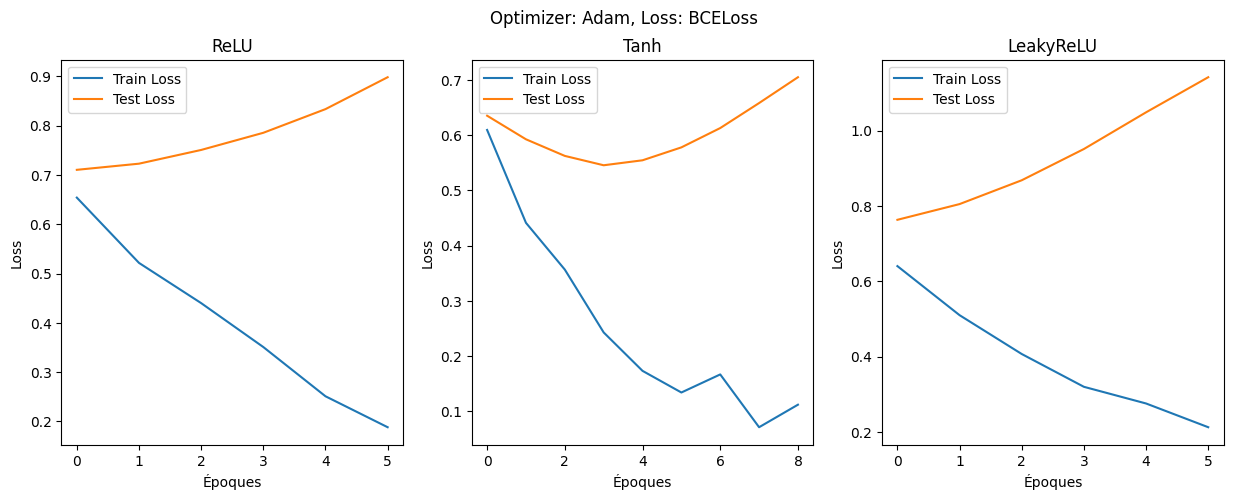


Testing optimizer Adam and loss function MSELoss
Early stopping déclenché à l'époque 6
Early stopping déclenché à l'époque 10
Early stopping déclenché à l'époque 6


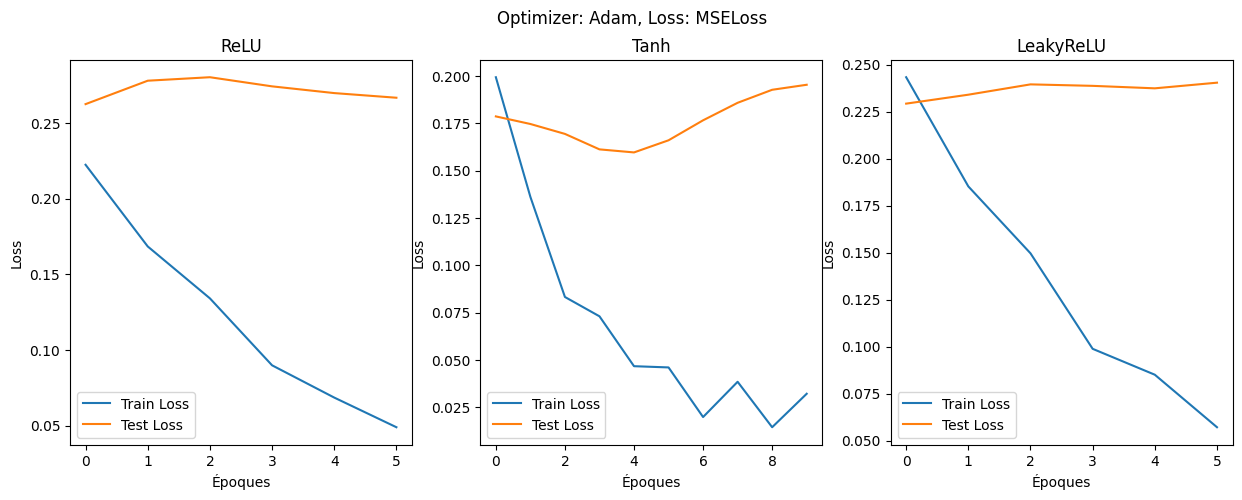


Testing optimizer SGD and loss function BCELoss
Early stopping déclenché à l'époque 6
Early stopping déclenché à l'époque 6


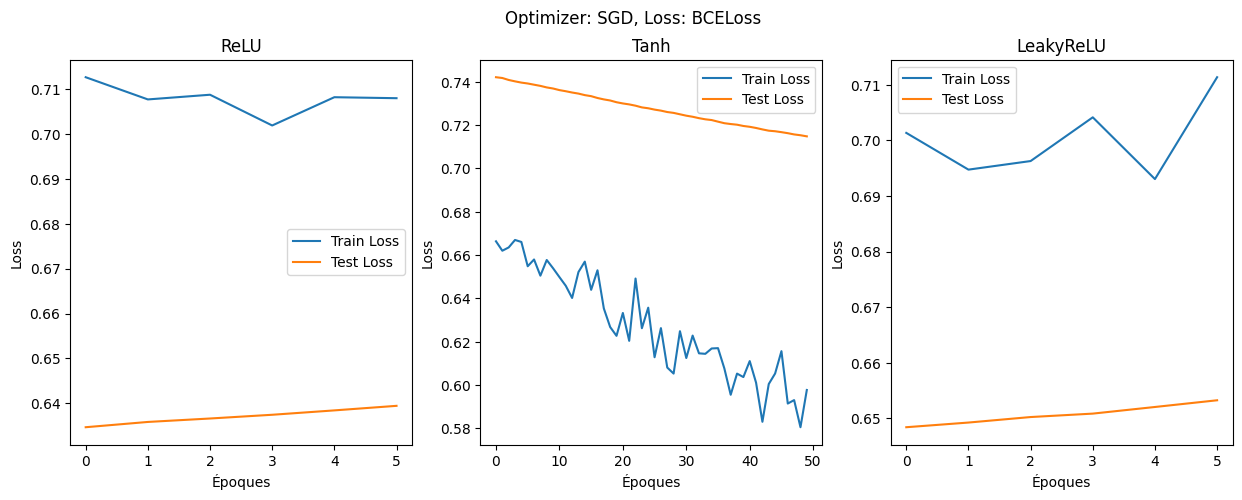


Testing optimizer SGD and loss function MSELoss
Early stopping déclenché à l'époque 6
Early stopping déclenché à l'époque 6


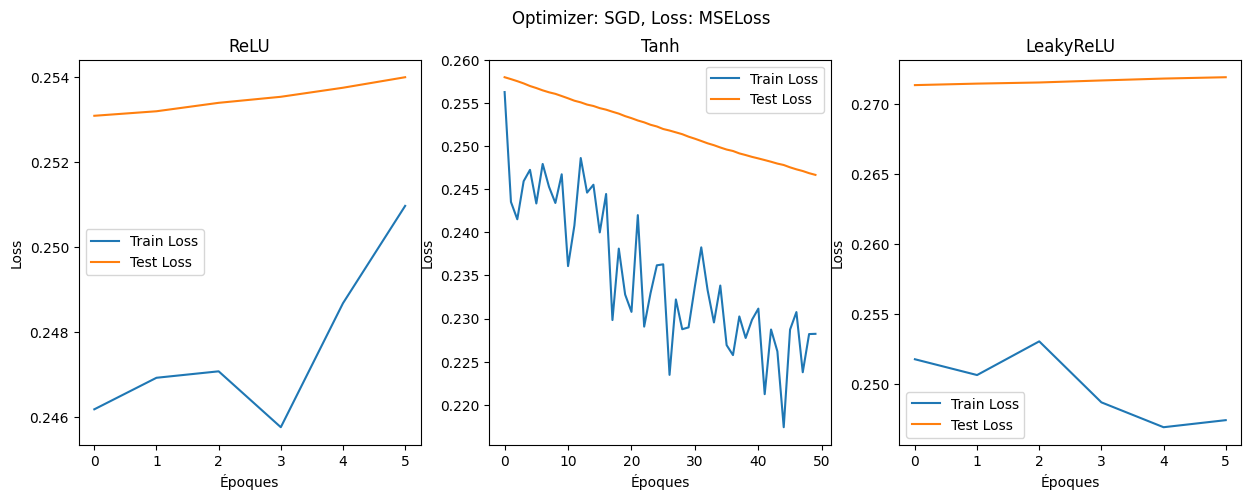


Testing optimizer RMSprop and loss function BCELoss
Early stopping déclenché à l'époque 7
Early stopping déclenché à l'époque 6
Early stopping déclenché à l'époque 6


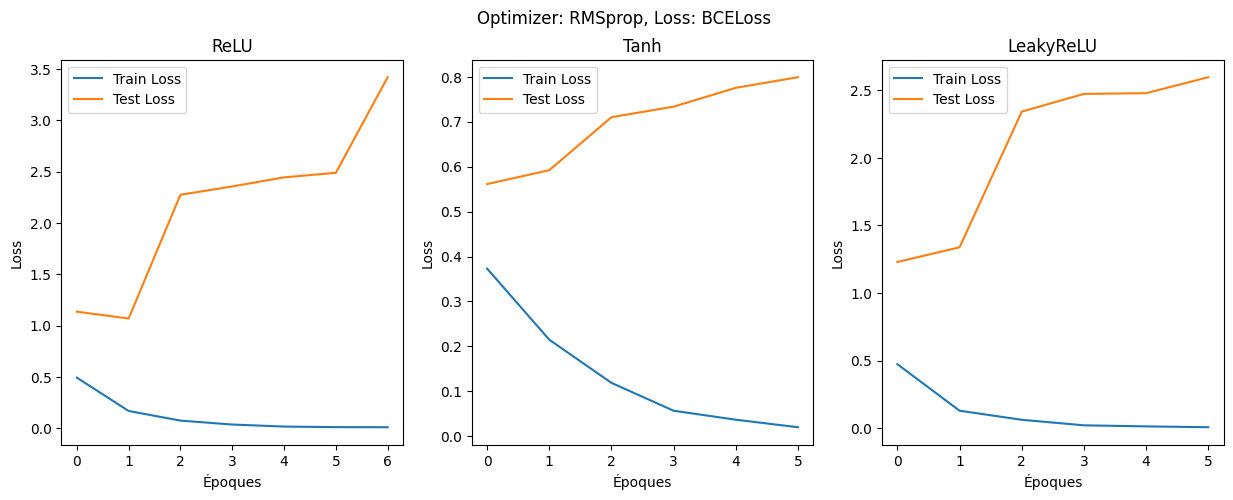


Testing optimizer RMSprop and loss function MSELoss
Early stopping déclenché à l'époque 7
Early stopping déclenché à l'époque 10
Early stopping déclenché à l'époque 10


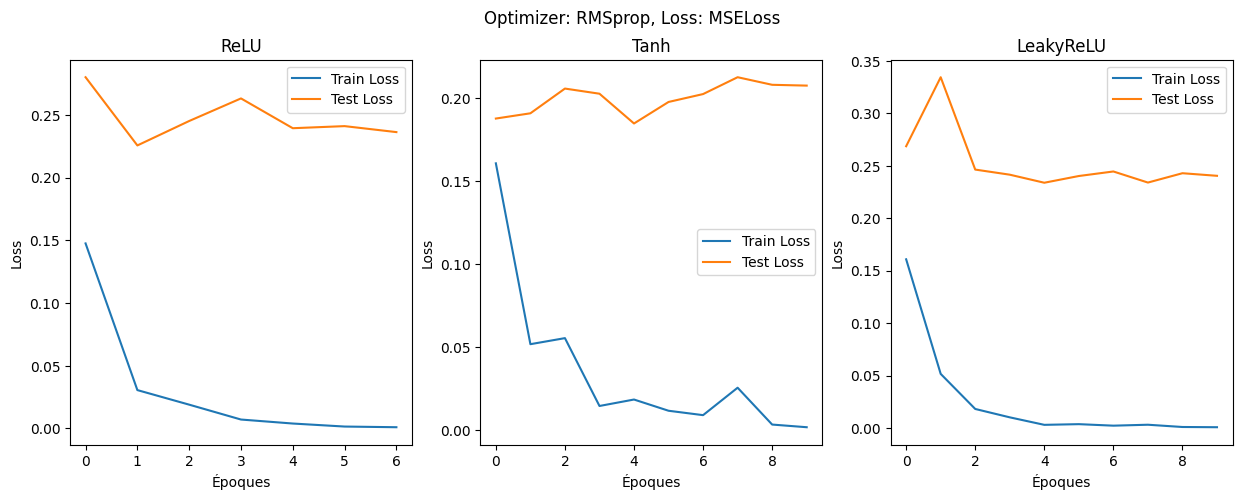


Meilleures combinaisons trouvées pour chaque configuration :
Optimiseur: Adam, Fonction de perte: BCELoss, Meilleure activation: Tanh, Test Loss: 0.5457
Optimiseur: Adam, Fonction de perte: MSELoss, Meilleure activation: Tanh, Test Loss: 0.1597
Optimiseur: SGD, Fonction de perte: BCELoss, Meilleure activation: ReLU, Test Loss: 0.6346
Optimiseur: SGD, Fonction de perte: MSELoss, Meilleure activation: Tanh, Test Loss: 0.2467
Optimiseur: RMSprop, Fonction de perte: BCELoss, Meilleure activation: Tanh, Test Loss: 0.5612
Optimiseur: RMSprop, Fonction de perte: MSELoss, Meilleure activation: Tanh, Test Loss: 0.1847

Meilleure combinaison générale : Optimiseur: Adam, Fonction de perte: MSELoss, Activation: Tanh, Test Loss: 0.1597

Total epochs testés : 213


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Charger les données d'entraînement et de test
data_df = pd.read_csv("data.csv")
test_df = pd.read_csv("test.csv")

# Séparer les caractéristiques et les étiquettes du jeu d'entraînement
X = data_df.drop(columns=['class']).values
y = data_df['class'].values

# Standardiser les données d'entraînement
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Préparer les données de test (sans les étiquettes)
test_data = test_df.iloc[:, 0].str.split(';', expand=True).values
test_scaled = scaler.transform(test_data)

# Convertir les données en tenseurs PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32)

# Créer des DataLoader pour l'entraînement et le test
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Définir le modèle avec une fonction d'activation variable
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation_function):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.activation = activation_function
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.output(x))
        return x

# Fonction d'entraînement avec early stopping
def train_with_early_stopping(optimizer_fn, loss_fn, activation_fn, patience=5, max_epochs=50):
    input_size = X_tensor.shape[1]
    model = NeuralNet(input_size, activation_fn)
    optimizer = optimizer_fn(model.parameters(), lr=0.001)
    criterion = loss_fn

    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Évaluer le modèle sur le jeu de test
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs in test_loader:
                outputs = model(inputs[0])
                test_loss += criterion(outputs.view(-1), torch.zeros(outputs.size(0))).item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Early stopping : Arrêter si la perte ne s'améliore pas
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0  # Réinitialiser la patience
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping déclenché à l'époque {epoch+1}")
                break

    return train_losses, test_losses, best_loss

# Fonction pour afficher les courbes côte à côte
def plot_comparison(train_losses_list, test_losses_list, labels, plot_title):
    plt.figure(figsize=(15, 5))
    for i in range(len(train_losses_list)):
        plt.subplot(1, len(train_losses_list), i + 1)
        plt.plot(train_losses_list[i], label='Train Loss')
        plt.plot(test_losses_list[i], label='Test Loss')
        plt.title(labels[i])
        plt.xlabel('Époques')
        plt.ylabel('Loss')
        plt.legend()
    plt.suptitle(plot_title)
    plt.show()

# Hyperparamètres à tester
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
loss_functions = [nn.BCELoss(), nn.MSELoss()]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.LeakyReLU()]
activation_labels = ['ReLU', 'Tanh', 'LeakyReLU']

# Boucle pour tester toutes les combinaisons avec Early Stopping et sélectionner la meilleure combinaison globale
def test_all_combinations():
    total_epochs = 0
    best_overall_loss = float('inf')
    best_combination = None
    best_results = []

    for optimizer_fn, loss_fn in itertools.product(optimizers, loss_functions):
        best_activation_fn = None
        best_test_loss = float('inf')
        best_train_losses = []
        best_test_losses = []
        activation_results = []

        print(f"\nTesting optimizer {optimizer_fn.__name__} and loss function {loss_fn.__class__.__name__}")

        # Test des différentes fonctions d'activation avec early stopping
        for activation_fn, activation_label in zip(activation_functions, activation_labels):
            train_losses, test_losses, final_test_loss = train_with_early_stopping(optimizer_fn, loss_fn, activation_fn, patience=5, max_epochs=50)

            # Calculer le nombre total d'époques testées
            total_epochs += len(train_losses)

            # Sauvegarder les résultats de chaque activation
            activation_results.append((train_losses, test_losses, activation_label))

            # Sélectionner la meilleure fonction d'activation basée sur la perte de validation (test)
            if final_test_loss < best_test_loss:
                best_test_loss = final_test_loss
                best_activation_fn = activation_fn
                best_train_losses = train_losses
                best_test_losses = test_losses

        # Afficher les résultats pour toutes les fonctions d'activation côte à côte
        labels = [f"{activation_label}" for activation_label in activation_labels]
        plot_comparison([res[0] for res in activation_results], [res[1] for res in activation_results], labels, f"Optimizer: {optimizer_fn.__name__}, Loss: {loss_fn.__class__.__name__}")

        # Sauvegarder la meilleure fonction d'activation pour cet ensemble (optimiseur + perte)
        best_results.append((optimizer_fn.__name__, loss_fn.__class__.__name__, best_activation_fn.__class__.__name__, best_test_loss))

        # Mettre à jour la meilleure combinaison globale
        if best_test_loss < best_overall_loss:
            best_overall_loss = best_test_loss
            best_combination = (optimizer_fn.__name__, loss_fn.__class__.__name__, best_activation_fn.__class__.__name__)

    # Afficher le récapitulatif des meilleurs résultats
    print("\nMeilleures combinaisons trouvées pour chaque configuration :")
    for result in best_results:
        print(f"Optimiseur: {result[0]}, Fonction de perte: {result[1]}, Meilleure activation: {result[2]}, Test Loss: {result[3]:.4f}")

    print(f"\nMeilleure combinaison générale : Optimiseur: {best_combination[0]}, Fonction de perte: {best_combination[1]}, Activation: {best_combination[2]}, Test Loss: {best_overall_loss:.4f}")
    print(f"\nTotal epochs testés : {total_epochs}")

# Lancer les tests pour toutes les combinaisons
test_all_combinations()

# **Code avec des hyperparametres trouvés avec optuna**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Fixer les graines pour garantir la reproductibilité
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Si tu utilises un GPU (CUDA), assure-toi que les calculs sont déterministes
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Charger les données depuis un fichier CSV
data = pd.read_csv("/content/data.csv")  # Assure-toi de spécifier le chemin correct

# Séparer les caractéristiques et la cible
X = data.drop(columns=["class"])  # Remplace "class" par le nom de ta colonne cible
y = data["class"]

# Appliquer RFE pour sélectionner les 300 meilleures caractéristiques
model_logistic = LogisticRegression(solver='liblinear')  # Utiliser la régression logistique comme estimateur
rfe = RFE(estimator=model_logistic, n_features_to_select=300)  # Sélectionner les 300 meilleures caractéristiques
X_rfe = rfe.fit_transform(X, y)

# Obtenir les colonnes sélectionnées par RFE
selected_columns = X.columns[rfe.support_]

# Split des données en ensemble d'entraînement et de validation (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Conversion des données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour la cible
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

# Créer les datasets et dataloaders pour l'entraînement et la validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Modèle final basé sur les meilleurs hyperparamètres
class MultiLayerOptimizedModel(nn.Module):
    def __init__(self, input_dim, n_units_l0, n_units_l1, dropout_rate, activation_fn):
        super(MultiLayerOptimizedModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, n_units_l0),
            nn.Dropout(dropout_rate),
            nn.Tanh(),
            nn.Linear(n_units_l0, n_units_l1),
            nn.Dropout(dropout_rate),
            nn.Tanh(),
            nn.Linear(n_units_l1, 1)  # La sortie finale est une seule unité pour la régression logistique
        )
        self.activation_fn = activation_fn

    def forward(self, x):
        return self.layers(x)

# Initialiser le modèle avec les meilleurs hyperparamètres
model_optimized = MultiLayerOptimizedModel(
    input_dim=X_train_tensor.shape[1],
    n_units_l0=335,  # 335 neurones dans la première couche cachée
    n_units_l1=367,  # 367 neurones dans la deuxième couche cachée
    dropout_rate=0.3857,  # Dropout de 38.57%
    activation_fn=torch.tanh  # tanh comme fonction d'activation
)

# Utiliser Adam comme optimiseur avec le taux d'apprentissage optimal
optimizer = optim.Adam(model_optimized.parameters(), lr=0.00738)
criterion = nn.BCEWithLogitsLoss()  # Utiliser BCEWithLogitsLoss

# Entraînement du modèle final
def train_final_model(num_epochs, criterion, optimizer, model, train_loader, val_loader):
    for epoch in range(num_epochs):
        model.train()  # Mettre le modèle en mode d'entraînement
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets.squeeze())  # Pas besoin de sigmoid avec BCEWithLogitsLoss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation à la fin de chaque époque
        model.eval()  # Mettre le modèle en mode évaluation
        val_running_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs).squeeze()
                val_loss = criterion(val_outputs, val_targets.squeeze())
                val_running_loss += val_loss.item()

        # Moyenne des pertes de validation
        val_loss_avg = val_running_loss / len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss_avg}')

# Entraîner le modèle final avec les hyperparamètres optimisés
num_epochs = 52  # 52 époques d'entraînement
train_final_model(num_epochs, criterion, optimizer, model_optimized, train_loader, val_loader)

# Charger les données de test depuis le fichier test.csv
test_data = pd.read_csv("/content/test.csv", sep=";")  # Utilise le bon séparateur



# Appliquer RFE sur les données de test pour conserver les mêmes caractéristiques sélectionnées
X_test_rfe = rfe.transform(test_data)  # Transformer les données de test avec les mêmes 300 caractéristiques

# Conversion des données de test en tenseurs PyTorch
X_test_tensor = torch.tensor(X_test_rfe, dtype=torch.float32)

# Prédiction sur les données de test
model_optimized.eval()  # Mettre le modèle en mode évaluation
with torch.no_grad():
    y_pred_test = model_optimized(X_test_tensor).squeeze()

# Convertir les prédictions en probabilités avec sigmoid
y_pred_test_proba = torch.sigmoid(y_pred_test).numpy()

# Créer un fichier de soumission pour Kaggle
submission = pd.DataFrame({
    'ID': test_data.index,  # Si le fichier test.csv contient une colonne ID, utilise test_data['ID']
    'TARGET': y_pred_test_proba  # Probabilités prédictives
})

# Sauvegarder le fichier de soumission
submission.to_csv("submission.csv", index=False)

print("Prédictions sauvegardées dans submission.csv")





Epoch [1/52], Training Loss: 0.7931991616884867, Validation Loss: 0.5484598875045776
Epoch [2/52], Training Loss: 0.5831629435221354, Validation Loss: 0.40819257497787476
Epoch [3/52], Training Loss: 0.5189014673233032, Validation Loss: 0.35023918747901917
Epoch [4/52], Training Loss: 0.42527587215105694, Validation Loss: 0.39847278594970703
Epoch [5/52], Training Loss: 0.3658856550852458, Validation Loss: 0.3186270296573639
Epoch [6/52], Training Loss: 0.3758614957332611, Validation Loss: 0.27237004041671753
Epoch [7/52], Training Loss: 0.2575729787349701, Validation Loss: 0.2629625201225281
Epoch [8/52], Training Loss: 0.2467571198940277, Validation Loss: 0.28246018290519714
Epoch [9/52], Training Loss: 0.13620498031377792, Validation Loss: 0.2710610032081604
Epoch [10/52], Training Loss: 0.2569352140029271, Validation Loss: 0.281480997800827
Epoch [11/52], Training Loss: 0.2137230783700943, Validation Loss: 0.26668184995651245
Epoch [12/52], Training Loss: 0.21359611054261526, Valid

# **Les modèles de machine learning testé: Logistic regression, Random Forest, KNN, SVM**


# **Meilleur score Random Forest**

In [23]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Charger les données d'entraînement
data_train = pd.read_csv('/content/data.csv')
X = data_train.drop(columns=['class'])  # Retirer la colonne cible
y = data_train['class']

# Supprimer les colonnes non numériques
non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

# Appliquer RFE pour sélectionner les 300 meilleures caractéristiques
model_logistic = LogisticRegression(solver='liblinear')
rfe = RFE(estimator=model_logistic, n_features_to_select=400)
X_rfe = rfe.fit_transform(X, y)

# Obtenir les colonnes sélectionnées par RFE
selected_columns = X.columns[rfe.support_]

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_rfe, y, test_size=0.3, random_state=42)

# Définir un dictionnaire de modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', probability=True)  # Utilisation du kernel 'linear'
}

# Entraîner et évaluer chaque modèle
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Entraîner le modèle

    # Faire des prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val)

    # Calculer les métriques
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')  # Moyenne pondérée pour les classes

    print(f"Model: {model_name}")
    print(f"Accuracy on Validation Set: {accuracy:.4f}")
    print(f"F1 Score on Validation Set: {f1:.4f}")
    print(classification_report(y_val, y_val_pred))
    print("-" * 60)

# Sélectionner le meilleur modèle (par exemple, Random Forest)
best_model = models['Random Forest']

# Charger les données de test
test_data = pd.read_csv("/content/test.csv", sep=";")

# Supprimer les colonnes non numériques dans les données de test
non_numeric_columns = test_data.select_dtypes(include=['object']).columns
test_data = test_data.drop(columns=non_numeric_columns)

# Appliquer les mêmes colonnes sélectionnées par RFE sur le jeu de test
X_test = test_data[selected_columns]  # Utiliser uniquement les colonnes sélectionnées

# Générer les prédictions (probabilités) pour le jeu de test
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Préparer le fichier de soumission pour Kaggle avec les probabilités comme TARGET
submission = pd.DataFrame({
    'ID': range(len(y_test_pred_proba)),  # Création d'IDs de 0 à n-1
    'TARGET': y_test_pred_proba
})

# Sauvegarder le fichier de soumission
submission.to_csv('sub.csv', index=False)
print("Fichier de soumission 'sub.csv' sauvegardé avec les probabilités comme TARGET.")

Model: Logistic Regression
Accuracy on Validation Set: 0.8125
F1 Score on Validation Set: 0.8074
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.83      0.90      0.86        21

    accuracy                           0.81        32
   macro avg       0.80      0.77      0.78        32
weighted avg       0.81      0.81      0.81        32

------------------------------------------------------------
Model: Random Forest
Accuracy on Validation Set: 0.9375
F1 Score on Validation Set: 0.9375
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.95      0.95      0.95        21

    accuracy                           0.94        32
   macro avg       0.93      0.93      0.93        32
weighted avg       0.94      0.94      0.94        32

------------------------------------------------------------
Model: KNN
Accuracy on Validation Se

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


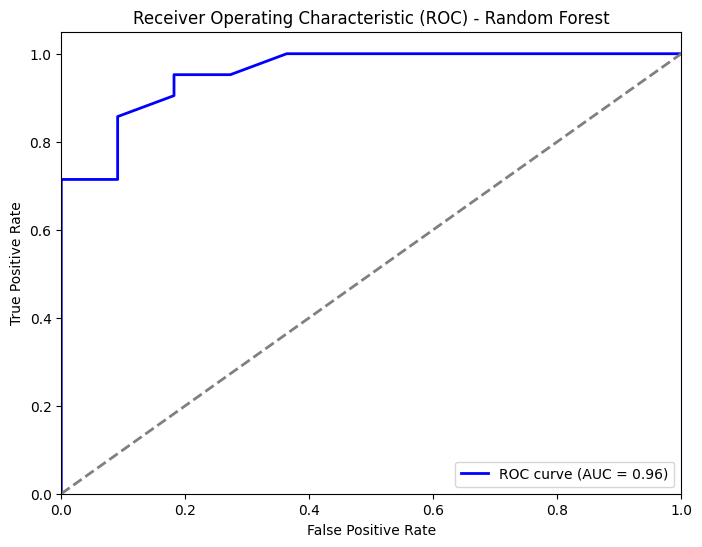

Log Loss (perte logarithmique) sur l'ensemble de validation : 0.3403


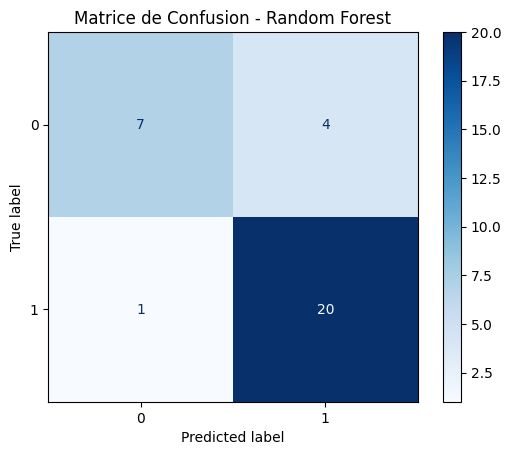

In [21]:
# Calculer les probabilités prédictives pour la classe 1
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

# 1. Courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()

# 2. Calcul et affichage de la log loss (perte logarithmique)
logloss = log_loss(y_val, y_val_pred_proba)
print(f'Log Loss (perte logarithmique) sur l\'ensemble de validation : {logloss:.4f}')

# 3. Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion - Random Forest')
plt.show()

La courbe ROC que tu as générée montre une bonne performance du modèle Random Forest sur l'ensemble de validation, avec un AUC (Area Under Curve) de 0.97, ce qui est excellent. Un AUC proche de 1 signifie que le modèle a une excellente capacité à discriminer entre les classes positives et négatives.

# **Que signifie cette courbe ?**
True Positive Rate (TPR) (ou sensibilité) est tracé en fonction du False Positive Rate (FPR). \\
La courbe ROC montre la relation entre le taux de vrais positifs et le taux de faux positifs à différents seuils de classification.
Plus la courbe est proche du coin supérieur gauche, mieux le modèle est capable de différencier entre les classes. \\
**Le AUC = 0.97** indique que le modèle a une très bonne capacité de discrimination.

# **La courbe du loss dans la validation set: Random forest**

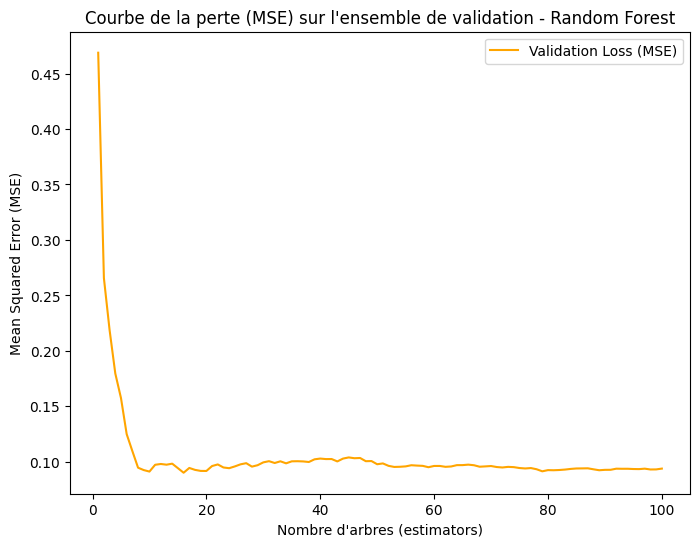

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# Initialiser le modèle Random Forest avec warm_start=True pour ajouter des arbres progressivement
rf_model = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42)

# Liste pour stocker les pertes sur le jeu de validation
validation_errors = []
n_estimators_range = range(1, 101)  # Ajouter progressivement jusqu'à 100 arbres

# Entraîner le modèle et calculer la perte sur l'ensemble de validation après chaque nouvel arbre
for n_estimators in n_estimators_range:
    rf_model.set_params(n_estimators=n_estimators)  # Ajouter un nouvel arbre
    rf_model.fit(X_train, y_train)  # Entraîner avec n_estimators arbres

    # Prédictions sur l'ensemble de validation
    y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe 1

    # Calculer la perte sur l'ensemble de validation (erreur quadratique moyenne ici)
    mse = mean_squared_error(y_val, y_val_pred_proba)
    validation_errors.append(mse)  # Ajouter la perte à la liste

# Tracer la courbe de la perte sur l'ensemble de validation
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_range, validation_errors, label='Validation Loss (MSE)', color='orange')
plt.xlabel('Nombre d\'arbres (estimators)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Courbe de la perte (MSE) sur l\'ensemble de validation - Random Forest')
plt.legend()
plt.show()


